## Импорт библиотек

In [83]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [84]:
!pip install -q phik

In [85]:
!pip install holidays

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PowerTransformer
import phik
from sklearn.preprocessing import StandardScaler
import holidays
import numpy as np
from sklearn.metrics import f1_score, precision_recall_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve
)
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)

## Импорт датасетов

In [87]:
train_df = pd.read_csv('df_train.csv',
                      parse_dates = ['CreatedDate'])
test_df = pd.read_csv('df_test.csv',
                     parse_dates = ['CreatedDate'])
test_df.columns

Index(['user_id', 'nm_id', 'CreatedDate', 'service', 'total_ordered',
       'PaymentType', 'IsPaid', 'count_items', 'unique_items',
       'avg_unique_purchase', 'is_courier', 'NmAge', 'Distance',
       'DaysAfterRegistration', 'number_of_orders', 'number_of_ordered_items',
       'mean_number_of_ordered_items', 'min_number_of_ordered_items',
       'max_number_of_ordered_items', 'mean_percent_of_ordered_items',
       'target'],
      dtype='object')

## Обработка данных

Извлечем из CreatedDate признаки времени суток, рабочего дня, праздничного дня

In [88]:
def get_features_from_date(df):
    df['day_of_week'] = df['CreatedDate'].dt.dayofweek #День недели (0-6)
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int) #выходной (0-1)
    df['hour'] = df['CreatedDate'].dt.hour
    df['time_of_day'] = pd.cut(
        df['hour'],
        bins=[0, 6, 12, 18, 24],
        labels=['Night', 'Morning', 'Afternoon', 'Evening'],
        right=False
    )
    df = df.drop('hour', axis = 1)
    ru_holidays = holidays.Russia(years=(2024, 2025))
    df['is_holiday'] = df['CreatedDate'].dt.date.isin(ru_holidays).astype(int) #Крупный праздник
    df['is_working_day'] = ((df['is_weekend'] == 0) & (df['is_holiday'] == 0)).astype(int) #Рабочий день
    df = df.drop('CreatedDate', axis = 1)
    return df
train_df_date_in_features = get_features_from_date(train_df)

In [89]:
test_df_date_in_features = get_features_from_date(test_df)

In [90]:
test_df_date_in_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14261 entries, 0 to 14260
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   user_id                        14261 non-null  int64   
 1   nm_id                          14261 non-null  int64   
 2   service                        14261 non-null  object  
 3   total_ordered                  14261 non-null  int64   
 4   PaymentType                    14261 non-null  object  
 5   IsPaid                         14261 non-null  bool    
 6   count_items                    14261 non-null  int64   
 7   unique_items                   14261 non-null  int64   
 8   avg_unique_purchase            14261 non-null  float64 
 9   is_courier                     14261 non-null  int64   
 10  NmAge                          14261 non-null  int64   
 11  Distance                       14261 non-null  int64   
 12  DaysAfterRegistration          1

Используем OHE для категориальных данных. Для тренировочного и тестового датасетов. Чтобы избежать утечки из теста, удаляем столбцы, которых нет в трейне

In [91]:
for col in train_df_date_in_features:
    num_of_unique_vals = len(list(train_df_date_in_features[col].unique()))
    print(num_of_unique_vals)
    if (num_of_unique_vals > 2) and (num_of_unique_vals < 10):
        train_dummies = pd.get_dummies(train_df_date_in_features)
        test_dummies = pd.get_dummies(test_df_date_in_features)
        
print('Training Features shape: ', train_dummies.shape)
print('Testing Features shape: ', test_dummies.shape)

35433
37224
2
286
11
2
1566
513
101
2
2207
5948
4687
137
729
2032
271
286
180
2
7
2
4
2
2
Training Features shape:  (105565, 39)
Testing Features shape:  (14261, 37)


In [92]:
train_labels = train_dummies['target']

train_dummies, test_dummies = train_dummies.align(test_dummies, join = 'inner', axis = 1)

train_dummies['target'] = train_labels

print('Training Features shape: ', train_dummies.shape)
print('Testing Features shape: ', test_dummies.shape)

Training Features shape:  (105565, 37)
Testing Features shape:  (14261, 37)


In [93]:
train_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105565 entries, 0 to 105564
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   user_id                        105565 non-null  int64  
 1   nm_id                          105565 non-null  int64  
 2   total_ordered                  105565 non-null  int64  
 3   IsPaid                         105565 non-null  bool   
 4   count_items                    105565 non-null  int64  
 5   unique_items                   105565 non-null  int64  
 6   avg_unique_purchase            105565 non-null  float64
 7   is_courier                     105565 non-null  int64  
 8   NmAge                          105565 non-null  int64  
 9   Distance                       105565 non-null  int64  
 10  DaysAfterRegistration          105565 non-null  int64  
 11  number_of_orders               105565 non-null  int64  
 12  number_of_ordered_items       

Распределения данных

In [94]:
def create_kde_plot_target(df, cols, n_cols = 2):
    n_rows = (len(cols) + n_cols - 1) // n_cols 
    plt.figure(figsize=(15, 5*n_rows))
    for i, col in enumerate(cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.kdeplot(df.loc[df['target'] == 0, col], label = 'target == 0')
        sns.kdeplot(df.loc[df['target'] == 1, col], label = 'target == 1')
        plt.xlabel(f'{col}')
        plt.ylabel('Density')
        plt.title(f'Distribution of {col}')
        plt.legend()
    plt.show()

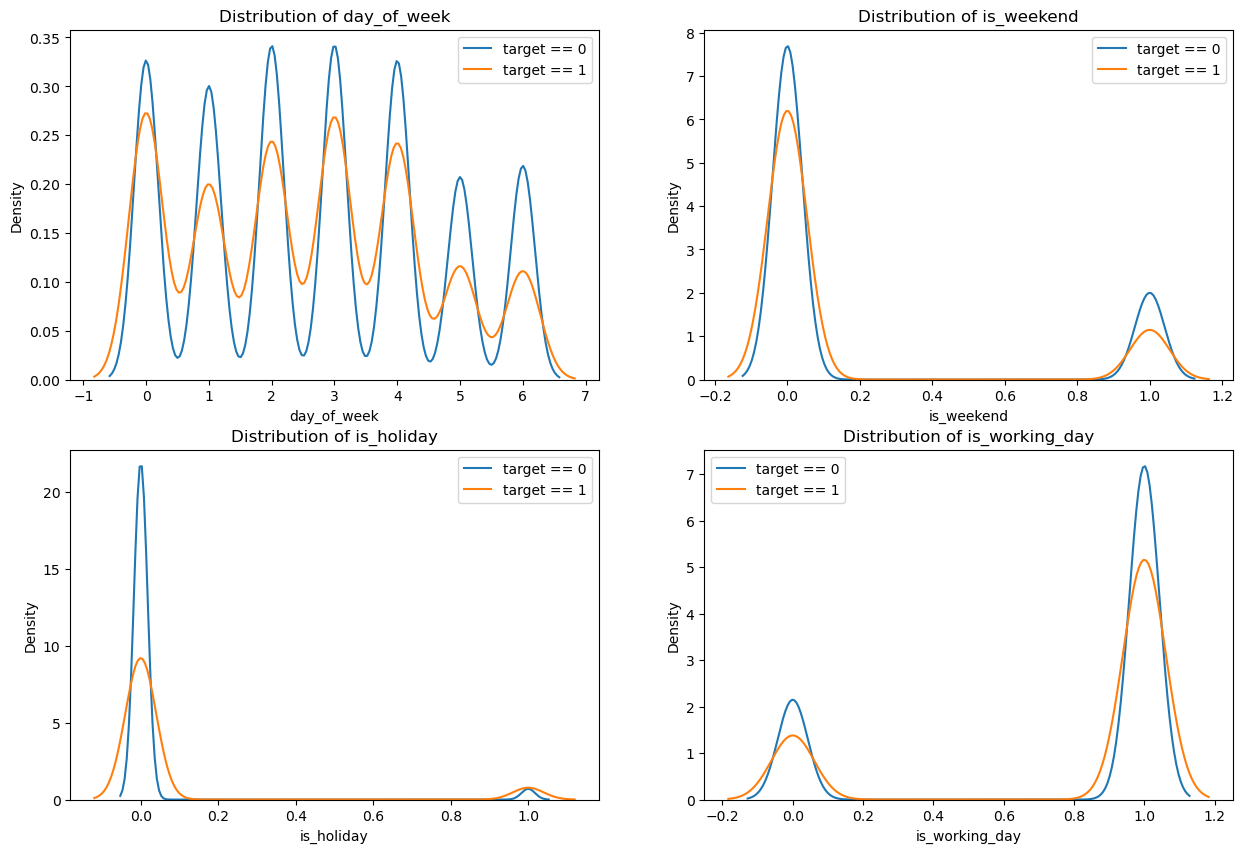

In [95]:
create_kde_plot_target(train_dummies, ['day_of_week', 'is_weekend', 'is_holiday', 'is_working_day'])

Судя по полученным распределениям, полученые из даты, признаки могут оказать положительный эффект на итоговую модель

Преобразуем булевы столбцы в числовые. Также удалим признаки user_id и nm_id

In [96]:
train_dummies_numeric = train_dummies.drop(['user_id', 'nm_id'], axis = 1)
bool_cols = train_dummies_numeric.select_dtypes(include=['bool']).columns
train_dummies_numeric[bool_cols] = train_dummies_numeric[bool_cols].astype(int)

In [97]:
train_dummies_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105565 entries, 0 to 105564
Data columns (total 35 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   total_ordered                  105565 non-null  int64  
 1   IsPaid                         105565 non-null  int32  
 2   count_items                    105565 non-null  int64  
 3   unique_items                   105565 non-null  int64  
 4   avg_unique_purchase            105565 non-null  float64
 5   is_courier                     105565 non-null  int64  
 6   NmAge                          105565 non-null  int64  
 7   Distance                       105565 non-null  int64  
 8   DaysAfterRegistration          105565 non-null  int64  
 9   number_of_orders               105565 non-null  int64  
 10  number_of_ordered_items        105565 non-null  int64  
 11  mean_number_of_ordered_items   105565 non-null  float64
 12  min_number_of_ordered_items   

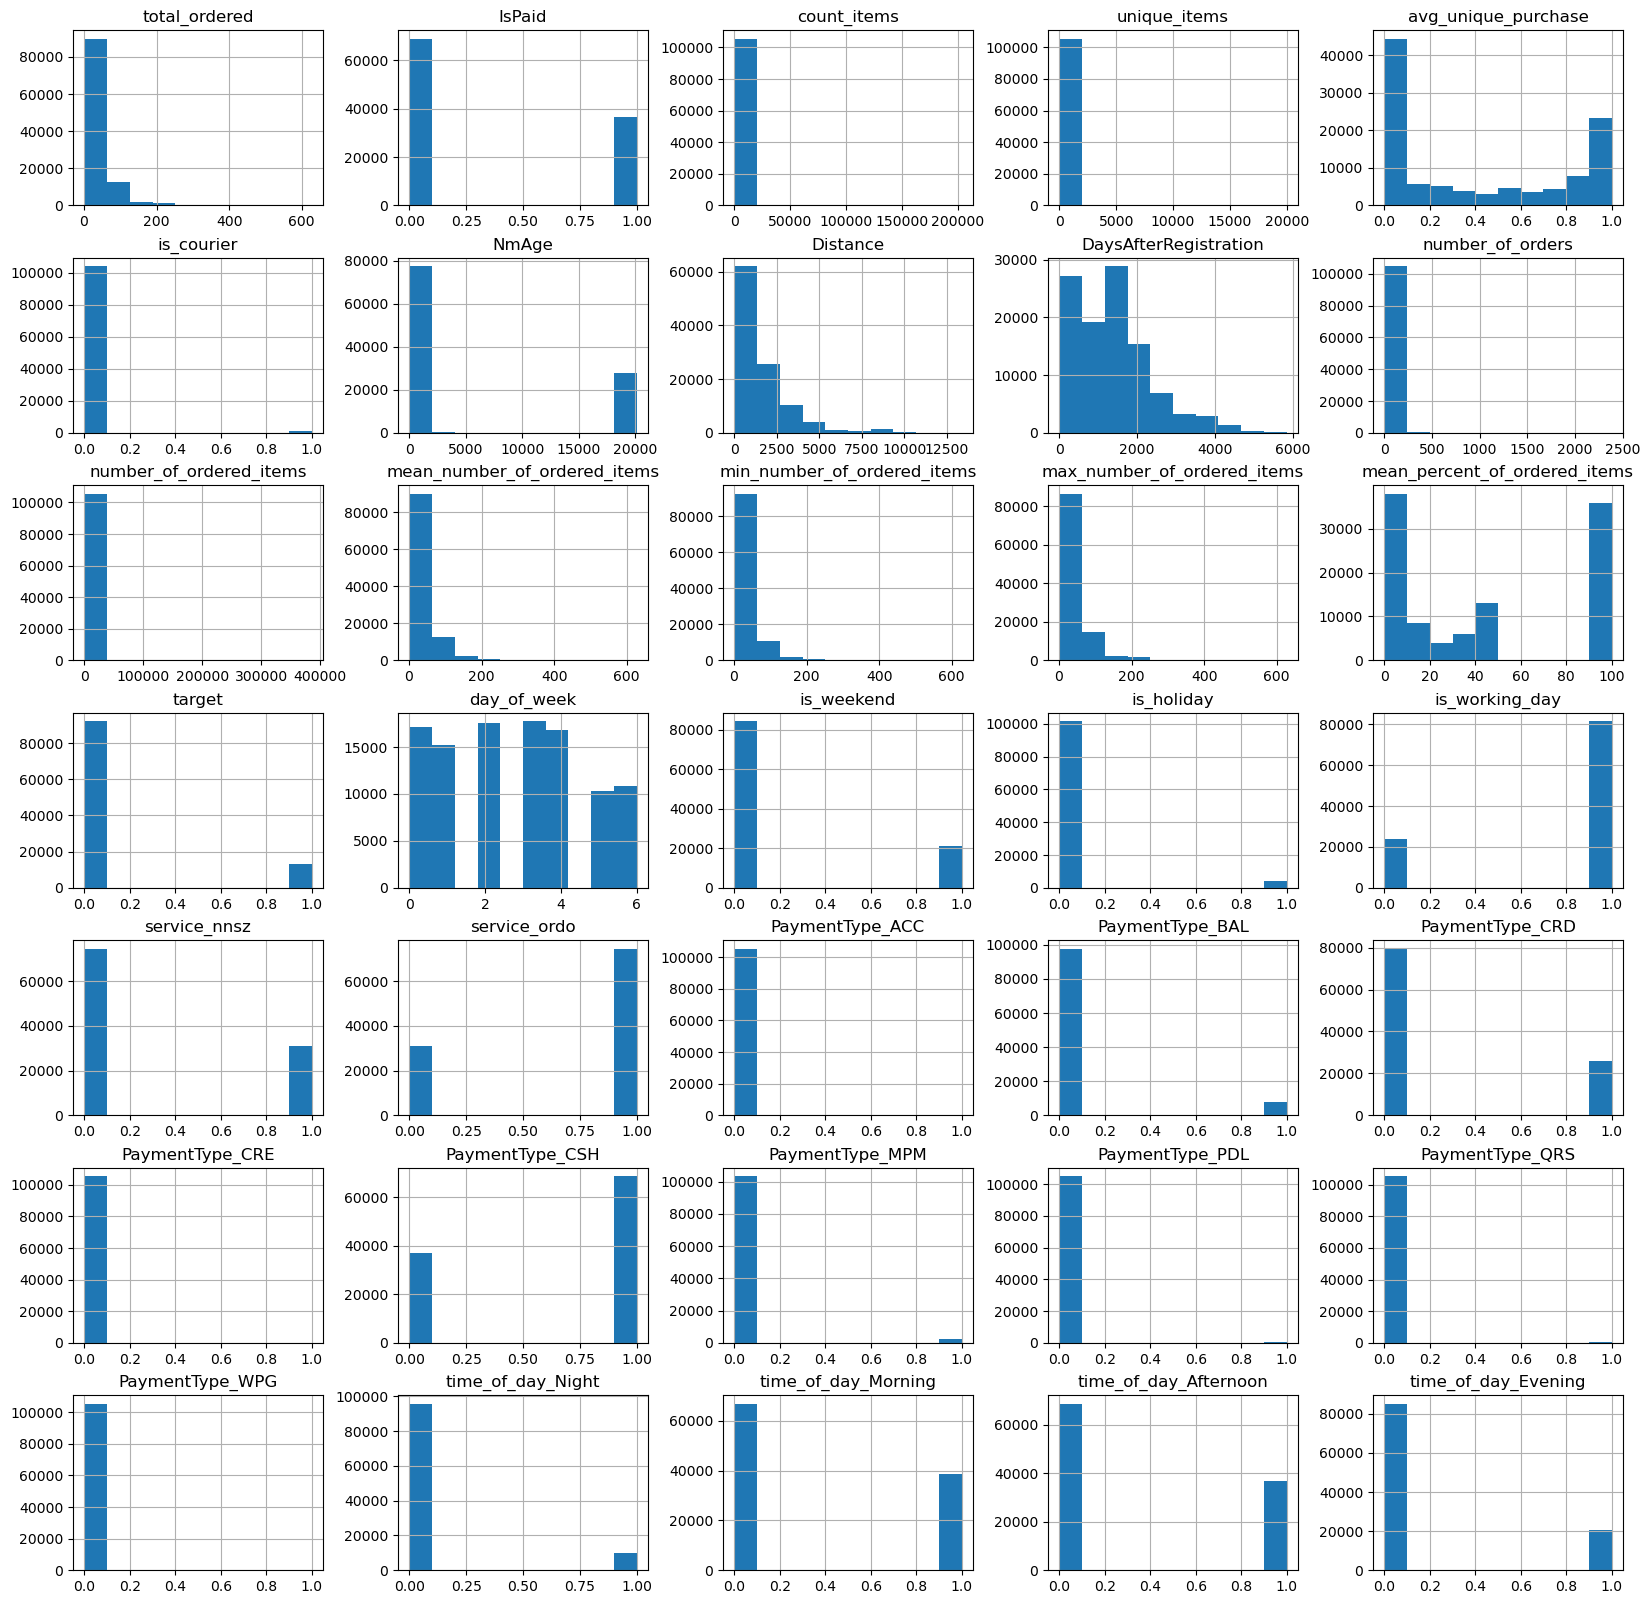

In [98]:
#Рассмотрим распределения данных
train_dummies_numeric.hist(figsize=(20, 20), layout=(-1, 5))
plt.show()

C:\Users\Михаил\AppData\Local\Temp\ipykernel_18148\4228326711.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[df['target'] == 1, col], label = 'target == 1')
C:\Users\Михаил\AppData\Local\Temp\ipykernel_18148\4228326711.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[df['target'] == 0, col], label = 'target == 0')
C:\Users\Михаил\AppData\Local\Temp\ipykernel_18148\4228326711.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[df['target'] == 1, col], label = 'target == 1')
C:\Users\Михаил\AppData\Local\Temp\ipykernel_18148\4228326711.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  

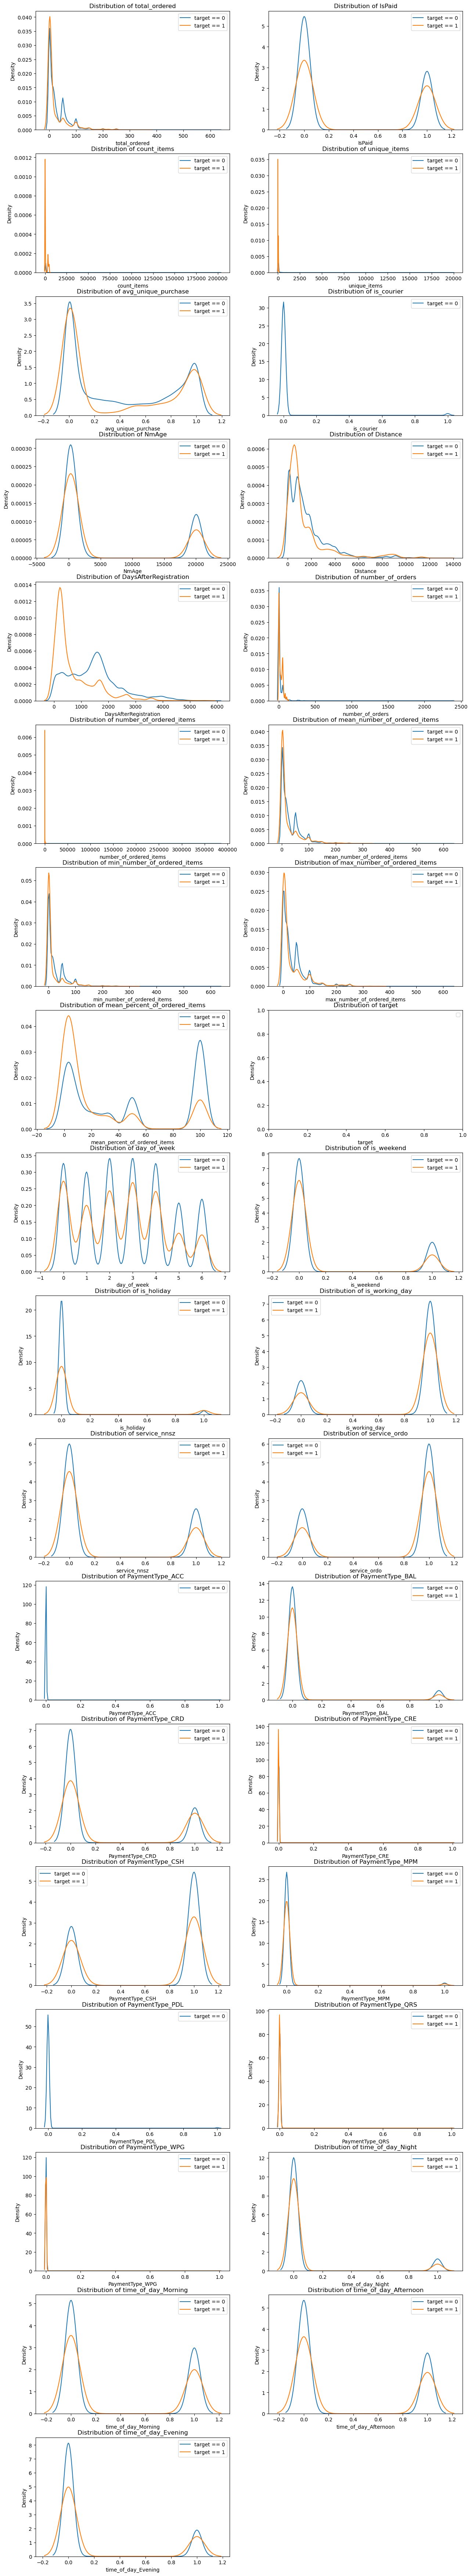

In [99]:
create_kde_plot_target(train_dummies_numeric, train_dummies_numeric.columns)

На некоторых графиках сложно понять распределения из-за длинных хвостов, поэтому уберём строки с крайними значениями признаков

Удалено 13733 строк


C:\Users\Михаил\AppData\Local\Temp\ipykernel_18148\4228326711.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[df['target'] == 0, col], label = 'target == 0')
C:\Users\Михаил\AppData\Local\Temp\ipykernel_18148\4228326711.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[df['target'] == 1, col], label = 'target == 1')
C:\Users\Михаил\AppData\Local\Temp\ipykernel_18148\4228326711.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\Михаил\AppData\Local\Temp\ipykernel_18148\4228326711.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[df['target'] == 0, col], label = 't

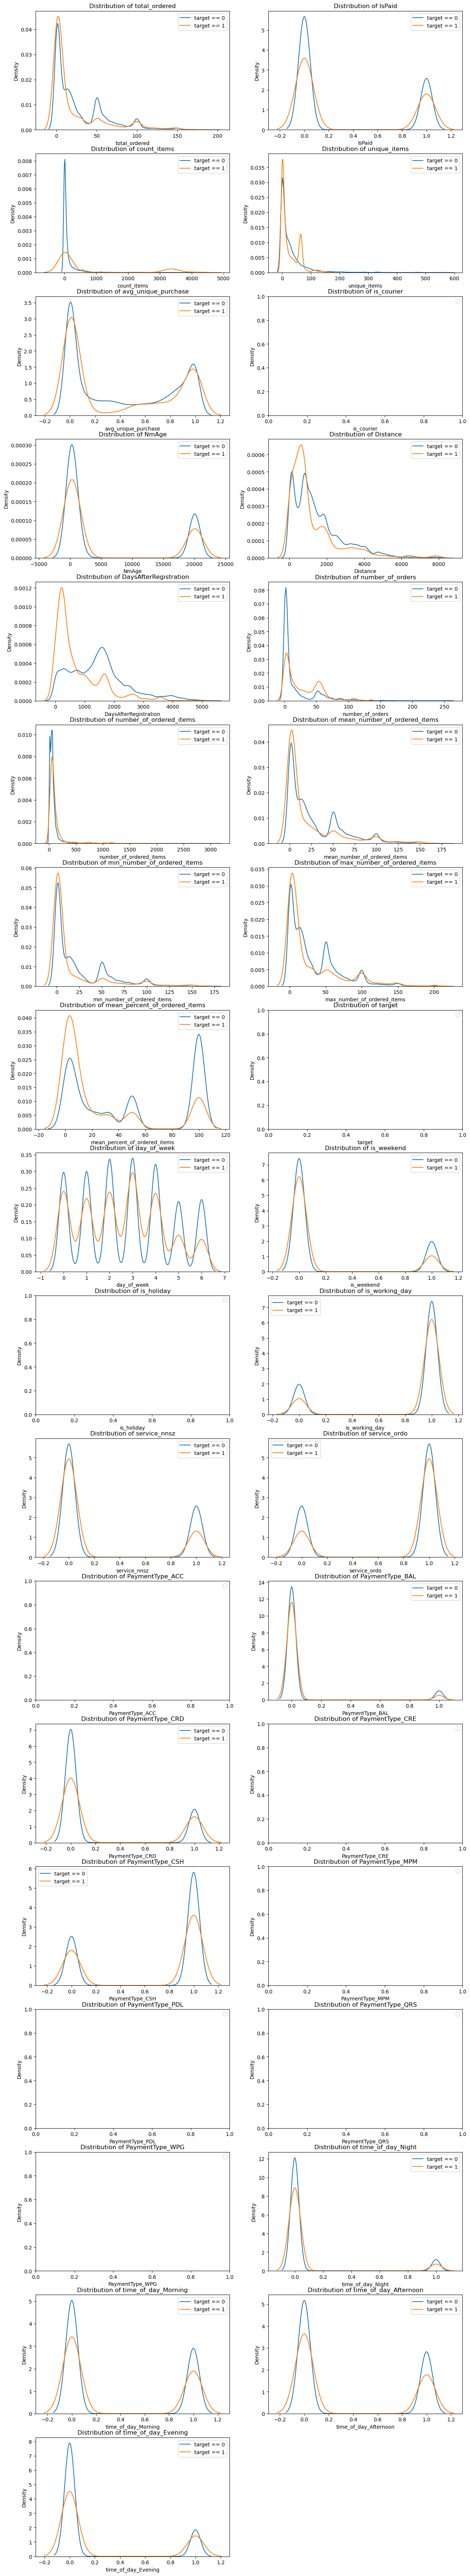

In [100]:
def antitrash(df, coef):
    df_antitrash = df[(np.abs(stats.zscore(df)) < coef).all(axis=1)]
    print(f'Удалено {df.shape[0] - df_antitrash.shape[0]} строк')
    return df_antitrash
train_antitrash = antitrash(df = train_dummies_numeric, coef = 4)
create_kde_plot_target(train_antitrash, train_antitrash.columns)

На основании некоторых признаков не удалось построить графики, так как мало записей. Признаки: ['is_courier', 'is_holiday', 'PaymentType_ACC', 'PaymentType_ACC', 'PaymentType_MPM', 'PaymentType_PDL', 'PaymentType_QRS', 'PaymentType_WPG']. is_courier также не отображался в первый раз, так как во всех записях, если есть клиентская доставка, то пользователь не является мошенником. Попробуем использовать это в пайплайне модели. Однако другие признаки не имеют таких особенностией и их распределения не указывали на мультимодальность данных, поэтому просто удалим столбцы с указанными признаками

In [101]:
train_antitrash = train_antitrash.drop(['is_courier', 'is_holiday', 'PaymentType_ACC', 'PaymentType_ACC', 'PaymentType_MPM', 'PaymentType_PDL', 'PaymentType_QRS', 'PaymentType_WPG'], axis = 1)

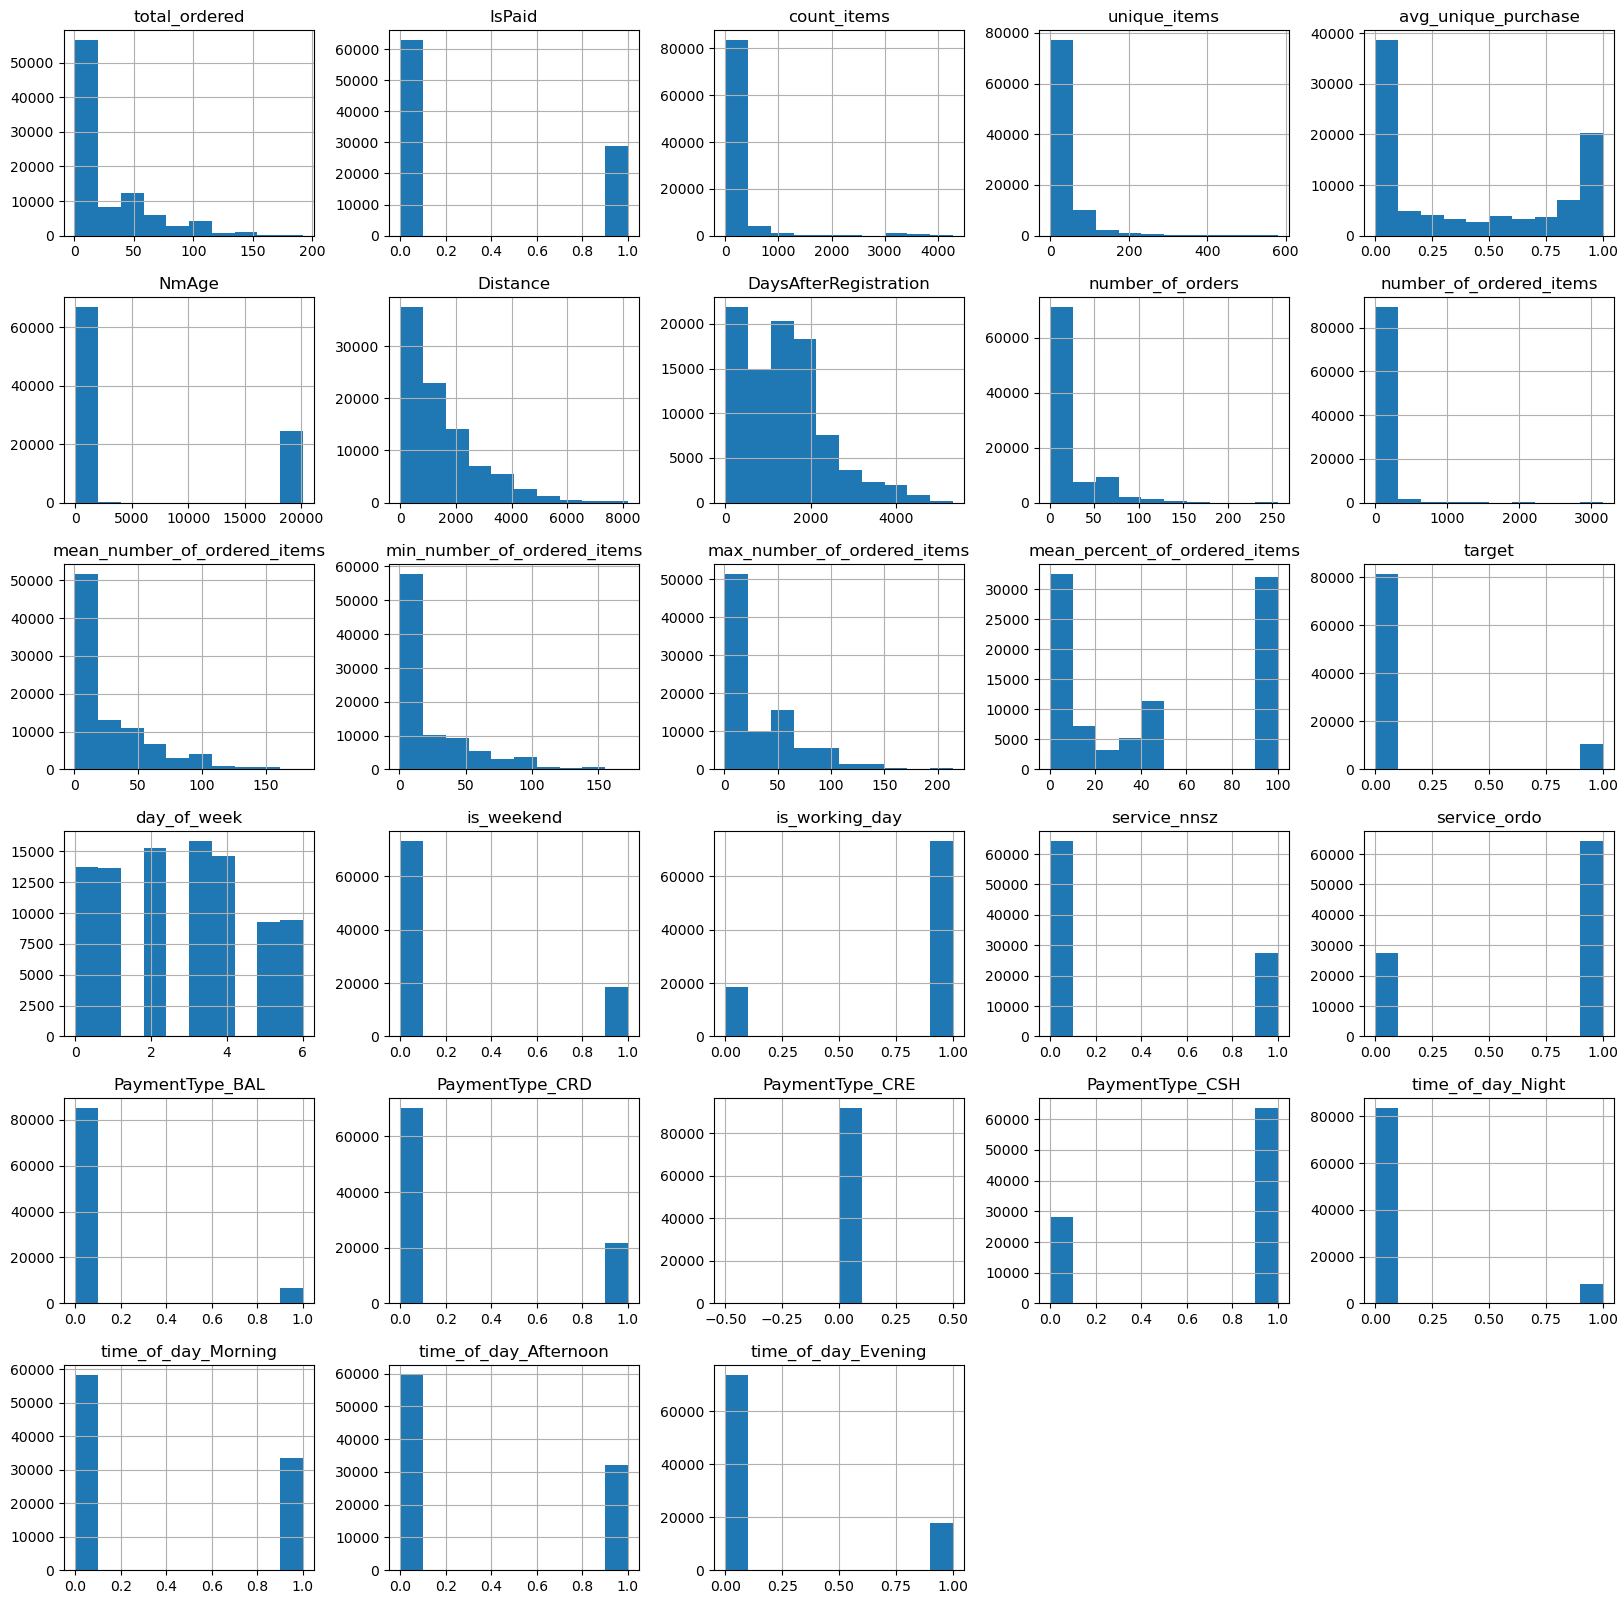

In [102]:
#Рассмотрим распределения данных
train_antitrash.hist(figsize=(20, 20), layout=(-1, 5))
plt.show()


Для некоторых признаков есть необходимость провести дополнительную очистку 

C:\Users\Михаил\AppData\Local\Temp\ipykernel_18148\4228326711.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[df['target'] == 0, col], label = 'target == 0')
C:\Users\Михаил\AppData\Local\Temp\ipykernel_18148\4228326711.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[df['target'] == 1, col], label = 'target == 1')
C:\Users\Михаил\AppData\Local\Temp\ipykernel_18148\4228326711.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\Михаил\AppData\Local\Temp\ipykernel_18148\4228326711.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[df['target'] == 0, col], label = 't

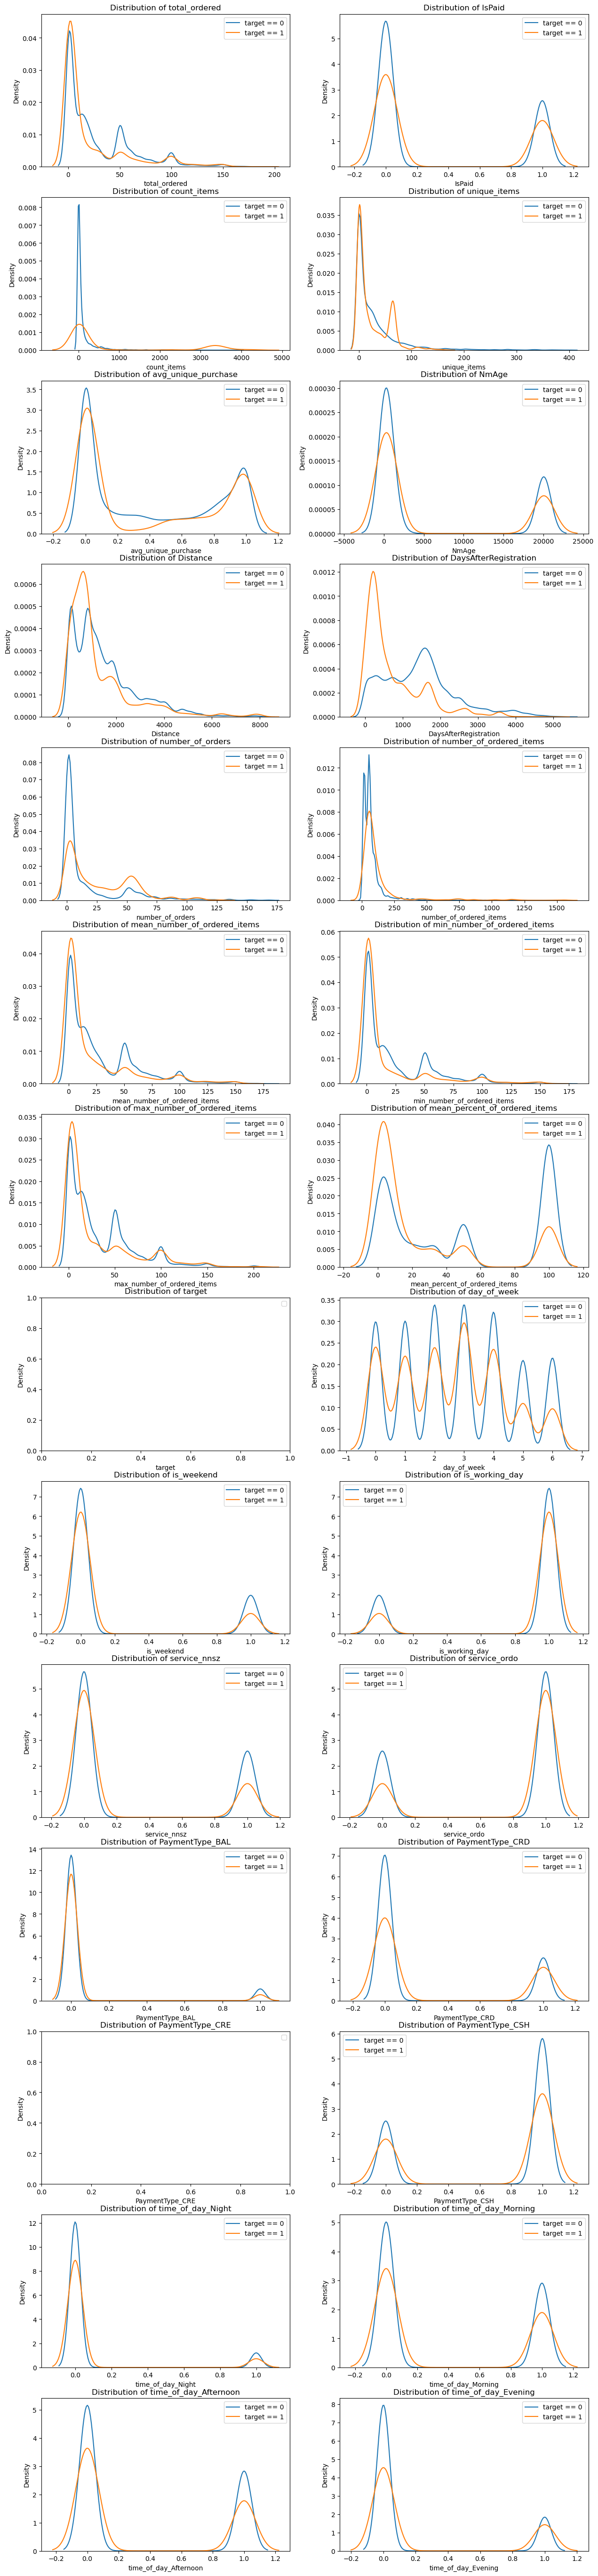

In [103]:
def remove_rows_with_custom_thresholds(df, threshold_dict):
    mask = pd.Series(True, index=df.index)
    for column, threshold in threshold_dict.items():
        mask &= df[column] <= threshold
    return df[mask]

thresholds = {
    'unique_items': 400,
    'number_of_orders': 180,
    'number_of_ordered_items': 1600
}

filtered_train = remove_rows_with_custom_thresholds(train_antitrash, thresholds)
create_kde_plot_target(filtered_train, filtered_train.columns)

In [104]:
filtered_train = filtered_train.drop(['PaymentType_CRE', 'service_nnsz'], axis = 1)

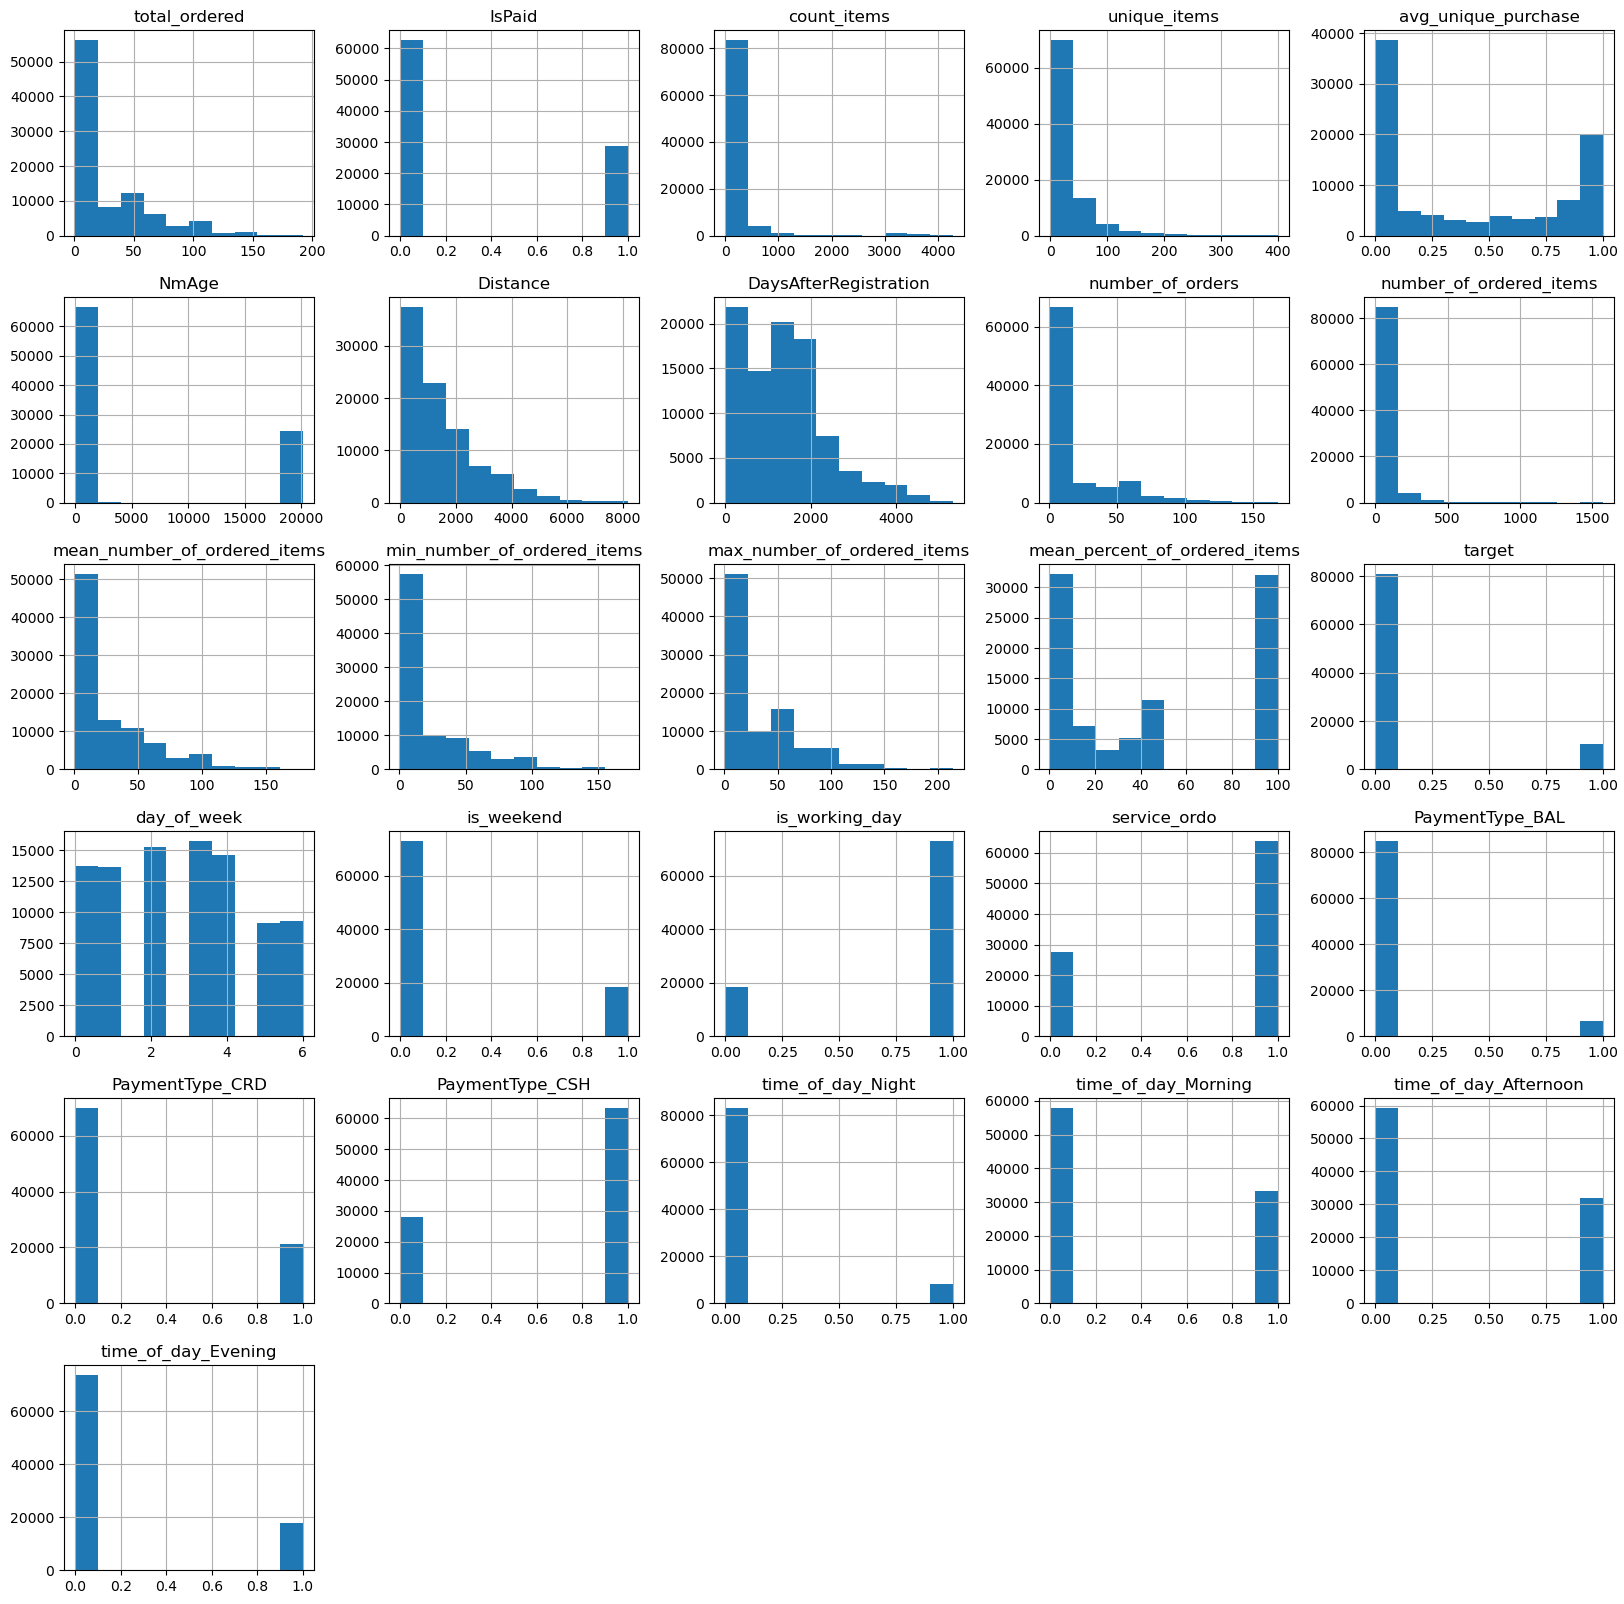

In [105]:
filtered_train.hist(figsize=(20, 20), layout=(-1, 5))
plt.show()

C:\Users\Михаил\AppData\Local\Temp\ipykernel_18148\244493565.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.91022059  1.91022059  1.90317611 ... -1.21693761 -1.21693761
 -1.21693761]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  transformed_train.update(transformed_data)
C:\Users\Михаил\AppData\Local\Temp\ipykernel_18148\244493565.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.22068489  1.36580467  0.17279802 ... -1.22068489 -1.22068489
  0.6334225 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  transformed_train.update(transformed_data)
C:\Users\Михаил\AppData\Local\Temp\ipykernel_18148\244493565.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.22792666  0.81

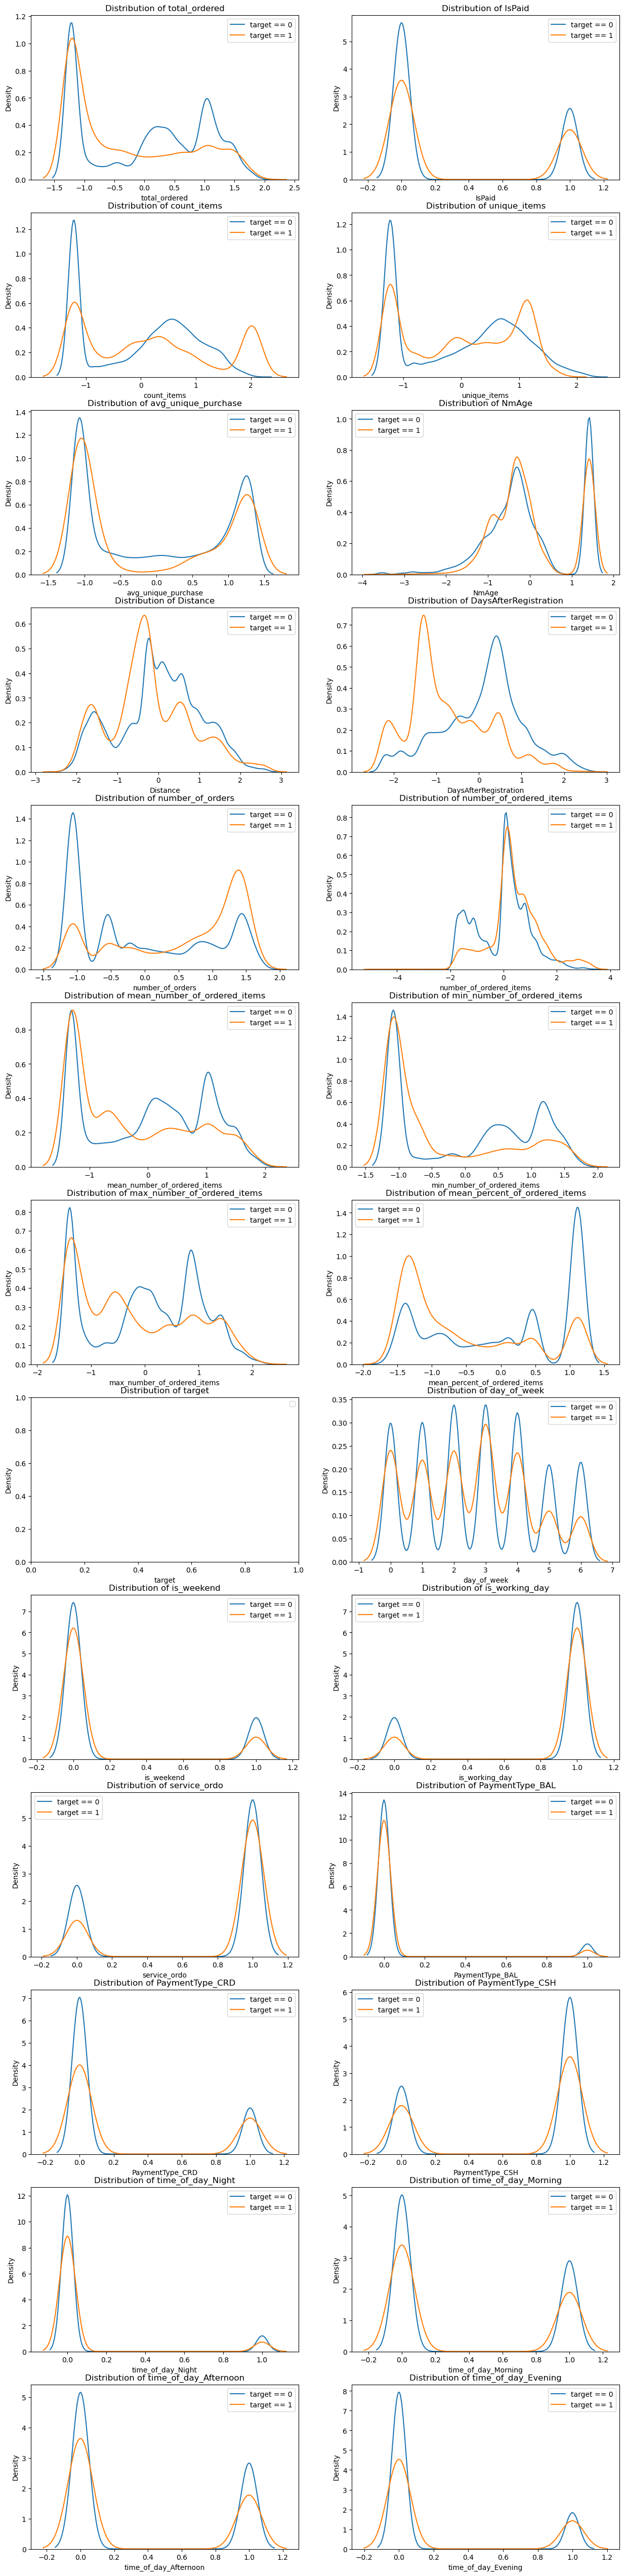

In [106]:
columns_to_transform = ['total_ordered', 'count_items', 'unique_items', 'avg_unique_purchase','NmAge','Distance','DaysAfterRegistration', 'number_of_orders', 'number_of_ordered_items', 'mean_number_of_ordered_items', 'min_number_of_ordered_items', 'max_number_of_ordered_items', 'mean_percent_of_ordered_items']

transformed_train = filtered_train.copy()
pt = PowerTransformer(method='yeo-johnson', standardize=True)

transformed_data = pd.DataFrame(
    pt.fit_transform(filtered_train[columns_to_transform]),
    columns=columns_to_transform,
    index=filtered_train.index
)

transformed_train.update(transformed_data)
create_kde_plot_target(transformed_train, transformed_train.columns)

In [107]:
transformed_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91412 entries, 1233 to 105564
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   total_ordered                  91412 non-null  float64
 1   IsPaid                         91412 non-null  int32  
 2   count_items                    91412 non-null  float64
 3   unique_items                   91412 non-null  float64
 4   avg_unique_purchase            91412 non-null  float64
 5   NmAge                          91412 non-null  float64
 6   Distance                       91412 non-null  float64
 7   DaysAfterRegistration          91412 non-null  float64
 8   number_of_orders               91412 non-null  float64
 9   number_of_ordered_items        91412 non-null  float64
 10  mean_number_of_ordered_items   91412 non-null  float64
 11  min_number_of_ordered_items    91412 non-null  float64
 12  max_number_of_ordered_items    91412 non-null  

Рассчитаем взаимные корреляции признаков и целевой переменной

In [108]:
from scipy.stats import chi2_contingency, pointbiserialr

def create_corr_matrix(df, target_col='target'):
    target = df[target_col]
    features = df.drop(columns=[target_col])
    
    num_cols = features.select_dtypes(include=np.number).columns
    binary_cols = [col for col in features.columns 
                 if features[col].nunique() == 2 and col in num_cols]

    target_corrs = {}
    for col in features.columns:
        if col in num_cols:
            if col in binary_cols:
                r, _ = pointbiserialr(features[col], target)
                target_corrs[col] = abs(r)
            else:
                target_corrs[col] = abs(features[col].corr(target, method='pearson'))

    sorted_features = sorted(target_corrs.keys(), 
                           key=lambda x: target_corrs[x], 
                           reverse=True)

    ordered_df = pd.concat([target, features[sorted_features]], axis=1)
 
    corr_matrix = pd.DataFrame(index=ordered_df.columns, 
                              columns=ordered_df.columns,
                              dtype=float)
    np.fill_diagonal(corr_matrix.values, 1.0)
    
    for i, col1 in enumerate(ordered_df.columns):
        for j, col2 in enumerate(ordered_df.columns):
            if i >= j:
                continue
            if (col1 in binary_cols or col2 in binary_cols) and not (col1 == target_col and col2 == target_col):
                r, _ = pointbiserialr(ordered_df[col1], ordered_df[col2])
                corr = r
            else:
                corr = ordered_df[col1].corr(ordered_df[col2], method='pearson')

            corr_matrix.loc[col1, col2] = corr
            corr_matrix.loc[col2, col1] = corr
    return corr_matrix

In [109]:
corr_matrix = create_corr_matrix(transformed_train)

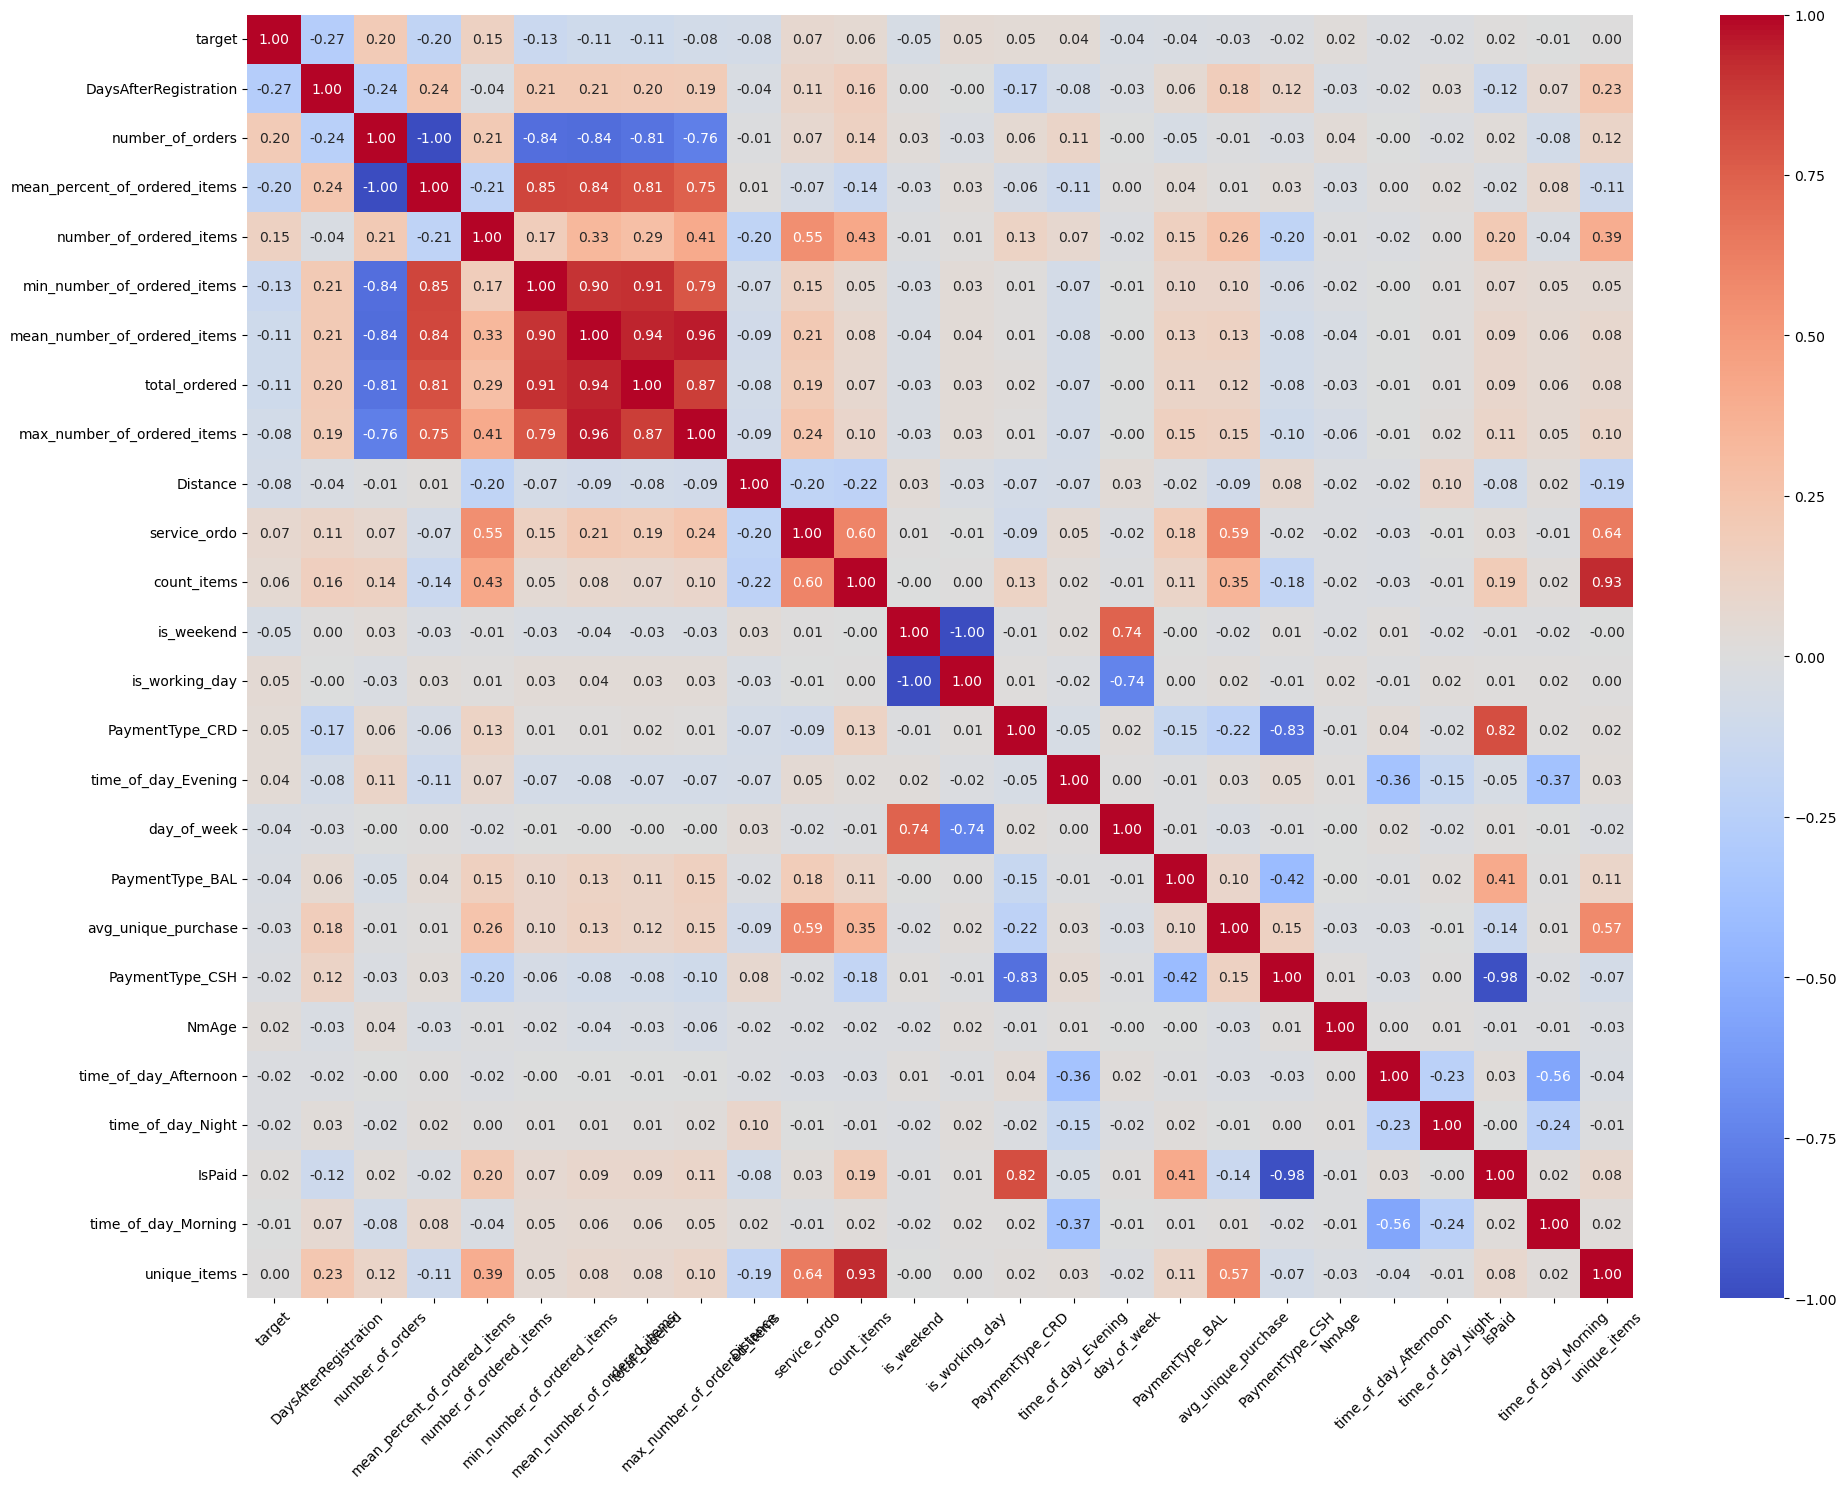

In [110]:
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Оставим только признак 'mean_percent_of_ordered_item' из группы сильно скореллированных признаков. Остальные скоррелированные признаки удалим позже, чтобы изучить их влияние на качество модели

In [111]:
train_for_model = transformed_train.drop(['number_of_orders', 'min_number_of_ordered_items', 'mean_number_of_ordered_items', 'total_ordered', 'max_number_of_ordered_items'], axis = 1)

In [112]:
train_for_model

IsPaid  count_items  unique_items  avg_unique_purchase     NmAge  \
1233         1    -1.220685     -1.227927            -1.075553 -0.139209   
1235         1     1.365805      0.816659            -0.779754 -0.705160   
1243         0     0.172798      0.418607             1.159040  1.415395   
1247         1     0.794644      0.994107             0.498640 -0.878055   
1250         1     1.465113      0.136546            -1.031028  0.177462   
...        ...          ...           ...                  ...       ...   
105560       1     2.081844      1.182982            -1.031028 -0.370895   
105561       0    -1.220685     -1.227927            -1.075553 -1.376231   
105562       0    -1.220685     -1.227927            -1.075553  0.484237   
105563       0    -1.220685     -1.227927            -1.075553  0.484237   
105564       0     0.633423     -0.209754            -0.740337 -0.708880   

        Distance  DaysAfterRegistration  number_of_ordered_items  \
1233   -0.675937               1.448556                 1.924317   
1235   -0.250592               1.184590                 1.937835   
1243   -1.797217               0.341019                 1.967509   
1247   -1.166435               1.294641                 3.118145   
1250   -1.951757              -0.106781                 1.964261   
...          ...                    ...                      ...   
105560 -0.486844              -1.298191                -3.581495   
105561 -0.717484              -0.093113                 1.194252   
105562 -0.100465               0.023446                -1.317961   
105563 -0.100465               0.023446                -1.317961   
105564 -1.066589              -1.123427                 0.026447   

        mean_percent_of_ordered_items  target  ...  is_weekend  \
1233                         0.126478       0  ...           1   
1235                         0.126478       0  ...           0   
1243                         0.458437       0  ...           0   
1247                        -0.363236       0  ...           0   
1250                         0.458437       0  ...           0   
...                               ...     ...  ...         ...   
105560                       0.126478       1  ...           0   
105561                       0.458437       0  ...           0   
105562                      -0.088192       1  ...           0   
105563                      -0.088192       1  ...           0   
105564                       0.458437       0  ...           0   

        is_working_day  service_ordo  PaymentType_BAL  PaymentType_CRD  \
1233                 0             0                0                1   
1235                 1             1                0                1   
1243                 1             1                0                0   
1247                 1             1                1                0   
1250                 1             1                0                1   
...                ...           ...              ...              ...   
105560               1             1                0                1   
105561               1             1                0                0   
105562               1             0                0                0   
105563               1             0                0                0   
105564               1             1                0                0   

        PaymentType_CSH  time_of_day_Night  time_of_day_Morning  \
1233                  0                  0                    0   
1235                  0                  0                    1   
1243                  1                  0                    0   
1247                  0                  0                    1   
1250                  0                  0                    0   
...                 ...                ...                  ...   
105560                0                  0                    1   
105561                1                  0                  

# Обучение модели

Чтобы избежать утечки данных из валидационного датасета для обучения модели спользуем filtered_train

In [113]:
train_labels = filtered_train['target']
train_for_model, test_for_model = filtered_train.align(test_dummies, join = 'inner', axis = 1)
train_for_model['target'] = train_labels

In [114]:
# Трансформируем тест
columns_to_transform = ['total_ordered', 'count_items', 'unique_items', 'avg_unique_purchase','NmAge','Distance','DaysAfterRegistration', 'number_of_orders', 'number_of_ordered_items', 'mean_number_of_ordered_items', 'min_number_of_ordered_items', 'max_number_of_ordered_items', 'mean_percent_of_ordered_items']

transformed_test = test_dummies.copy()

transformed_data_test = pd.DataFrame(
    pt.transform(transformed_test[columns_to_transform]),
    columns=columns_to_transform,
    index=transformed_test.index
)

transformed_test.update(transformed_data_test)

C:\Users\Михаил\AppData\Local\Temp\ipykernel_18148\3154839000.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2.9128658   2.59787975  2.51499971 ... -1.21693761 -1.21693761
 -1.21693761]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  transformed_test.update(transformed_data_test)
C:\Users\Михаил\AppData\Local\Temp\ipykernel_18148\3154839000.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.22068489  0.90560213 -1.22068489 ... -0.87413621 -0.87413621
 -1.22068489]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  transformed_test.update(transformed_data_test)
C:\Users\Михаил\AppData\Local\Temp\ipykernel_18148\3154839000.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.227

## Бейслайн (логистическая регрессия на данных с мильтиколлинеарностью в признаках)

In [115]:
def find_optimal_threshold(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba, pos_label=1)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_idx = np.argmax(f1_scores)
    return thresholds[optimal_idx]

def get_coeffs_table(model, df):
    coeffs_logr_table = pd.DataFrame({
    'Признак': model.feature_names_in_,
    'Coefficient': model[1].coef_[0]
    }).sort_values(by = 'Coefficient', key=lambda x: np.abs(x), ascending = False)
    print(coeffs_logr_table)
    return coeffs_logr_table

def evaluate_model(model, X, y_true, threshold=0.5):
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    
    print(f"\nОценка с порогом {threshold:.3f}:")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_proba):.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    
    return {
        'roc_auc': roc_auc_score(y_true, y_proba),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'classification_report': classification_report(y_true, y_pred, output_dict=True),
        'y_proba': y_proba,
        'y_pred': y_pred
    }

def create_optimal_logr(X_train_for_model, y_train_for_model, numeric_features):
    # Разделяем данные на обучающую и валидационную выборки для подбора порога
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_for_model, 
        y_train_for_model, 
        test_size=0.2, 
        random_state=15,
        stratify=y_train_for_model
    )


    preprocessor = ColumnTransformer(
        transformers=[
            ('power', PowerTransformer(method='yeo-johnson', standardize=True), numeric_features)
        ],
        remainder='passthrough'
    )
    
    # Создаем и обучаем пайплайн с лучшими параметрами
    pipeline_logr = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            class_weight='balanced',
            solver='liblinear'))
    ])

    param_grid = {'classifier__C': [0.01, 0.1, 1],
     'classifier__max_iter': [100, 500, 1000],
     'classifier__penalty': ['l1', 'l2']
    }
    
    # Подбираем гиперпараметры
    grid = GridSearchCV(
        pipeline_logr, 
        param_grid, 
        cv=5, 
        scoring='roc_auc', 
        n_jobs=5, 
        verbose=4
    )

    grid.fit(X_train, y_train)
    
    # Лучшая модель
    best_model = grid.best_estimator_
    print('Лучшие параметры:', grid.best_params_)
    print('Лучший ROC-AUC:', grid.best_score_)

    # Получаем вероятности на валидационной выборке
    y_val_proba = best_model.predict_proba(X_val)[:, 1]

    # Находим оптимальный порог
    optimal_threshold = find_optimal_threshold(y_val, y_val_proba)
    print(f'Оптимальный порог: {optimal_threshold:.3f}')

    #Метрики на валидации
    val_metrics = evaluate_model(best_model, X_val, y_val, optimal_threshold)

    #Важности признаков
    coeffs_table = get_coeffs_table(best_model, X_train)
    
    return best_model, optimal_threshold, coeffs_table


In [116]:

X_train_logr_base = filtered_train.drop(['target'], axis = 1)
y_train_logr_base = filtered_train['target']

numeric_features = [
    'total_ordered', 'count_items', 'unique_items', 'avg_unique_purchase',
    'NmAge', 'Distance', 'DaysAfterRegistration', 'number_of_orders',
    'number_of_ordered_items', 'mean_number_of_ordered_items',
    'min_number_of_ordered_items', 'max_number_of_ordered_items',
    'mean_percent_of_ordered_items'
]

best_model_logr_base, optimal_threshold_logr_base, coeffs_table_logr_base = create_optimal_logr(X_train_logr_base, y_train_logr_base, numeric_features)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Лучшие параметры: {'classifier__C': 1, 'classifier__max_iter': 100, 'classifier__penalty': 'l2'}
Лучший ROC-AUC: 0.8129408868138903
Оптимальный порог: 0.626

Оценка с порогом 0.626:
ROC-AUC: 0.8167
Confusion Matrix:
 [[13852  2320]
 [  766  1345]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.86      0.90     16172
           1       0.37      0.64      0.47      2111

    accuracy                           0.83     18283
   macro avg       0.66      0.75      0.68     18283
weighted avg       0.88      0.83      0.85     18283

                          Признак  Coefficient
13  mean_percent_of_ordered_items    -1.874883
12    max_number_of_ordered_items    -1.380551
2                     count_items    -1.256900
1                          IsPaid     1.140677
6                        Distance    -0.884481
17                   service_ordo     0.861213
20         

In [117]:
test_metrics_logr_base = evaluate_model(best_model_logr_base, test_for_model.drop('target', axis=1), test_for_model['target'], optimal_threshold_logr_base)


Оценка с порогом 0.626:
ROC-AUC: 0.6766
Confusion Matrix:
 [[9986 2469]
 [ 977  829]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.80      0.85     12455
           1       0.25      0.46      0.32      1806

    accuracy                           0.76     14261
   macro avg       0.58      0.63      0.59     14261
weighted avg       0.83      0.76      0.79     14261



Теперь уберём некоторые скоррелированные признаки

## Логистическая регрессия на очищенных от мультиколлинеарности данных

Чтобы избежать утечки данных, построим корреляционную матрицу на основе только тренировочной выборки, оставив валидационную

In [118]:
train_features, val_features, train_target, val_target = train_test_split(
        filtered_train.drop(['target'], axis = 1), 
        filtered_train['target'], 
        test_size=0.2, 
        random_state=15,
        stratify=filtered_train['target']
    )
train_dataset = train_features.copy()
train_dataset['target'] = train_target
val_dataset = val_features.copy()
val_dataset['target'] = val_target

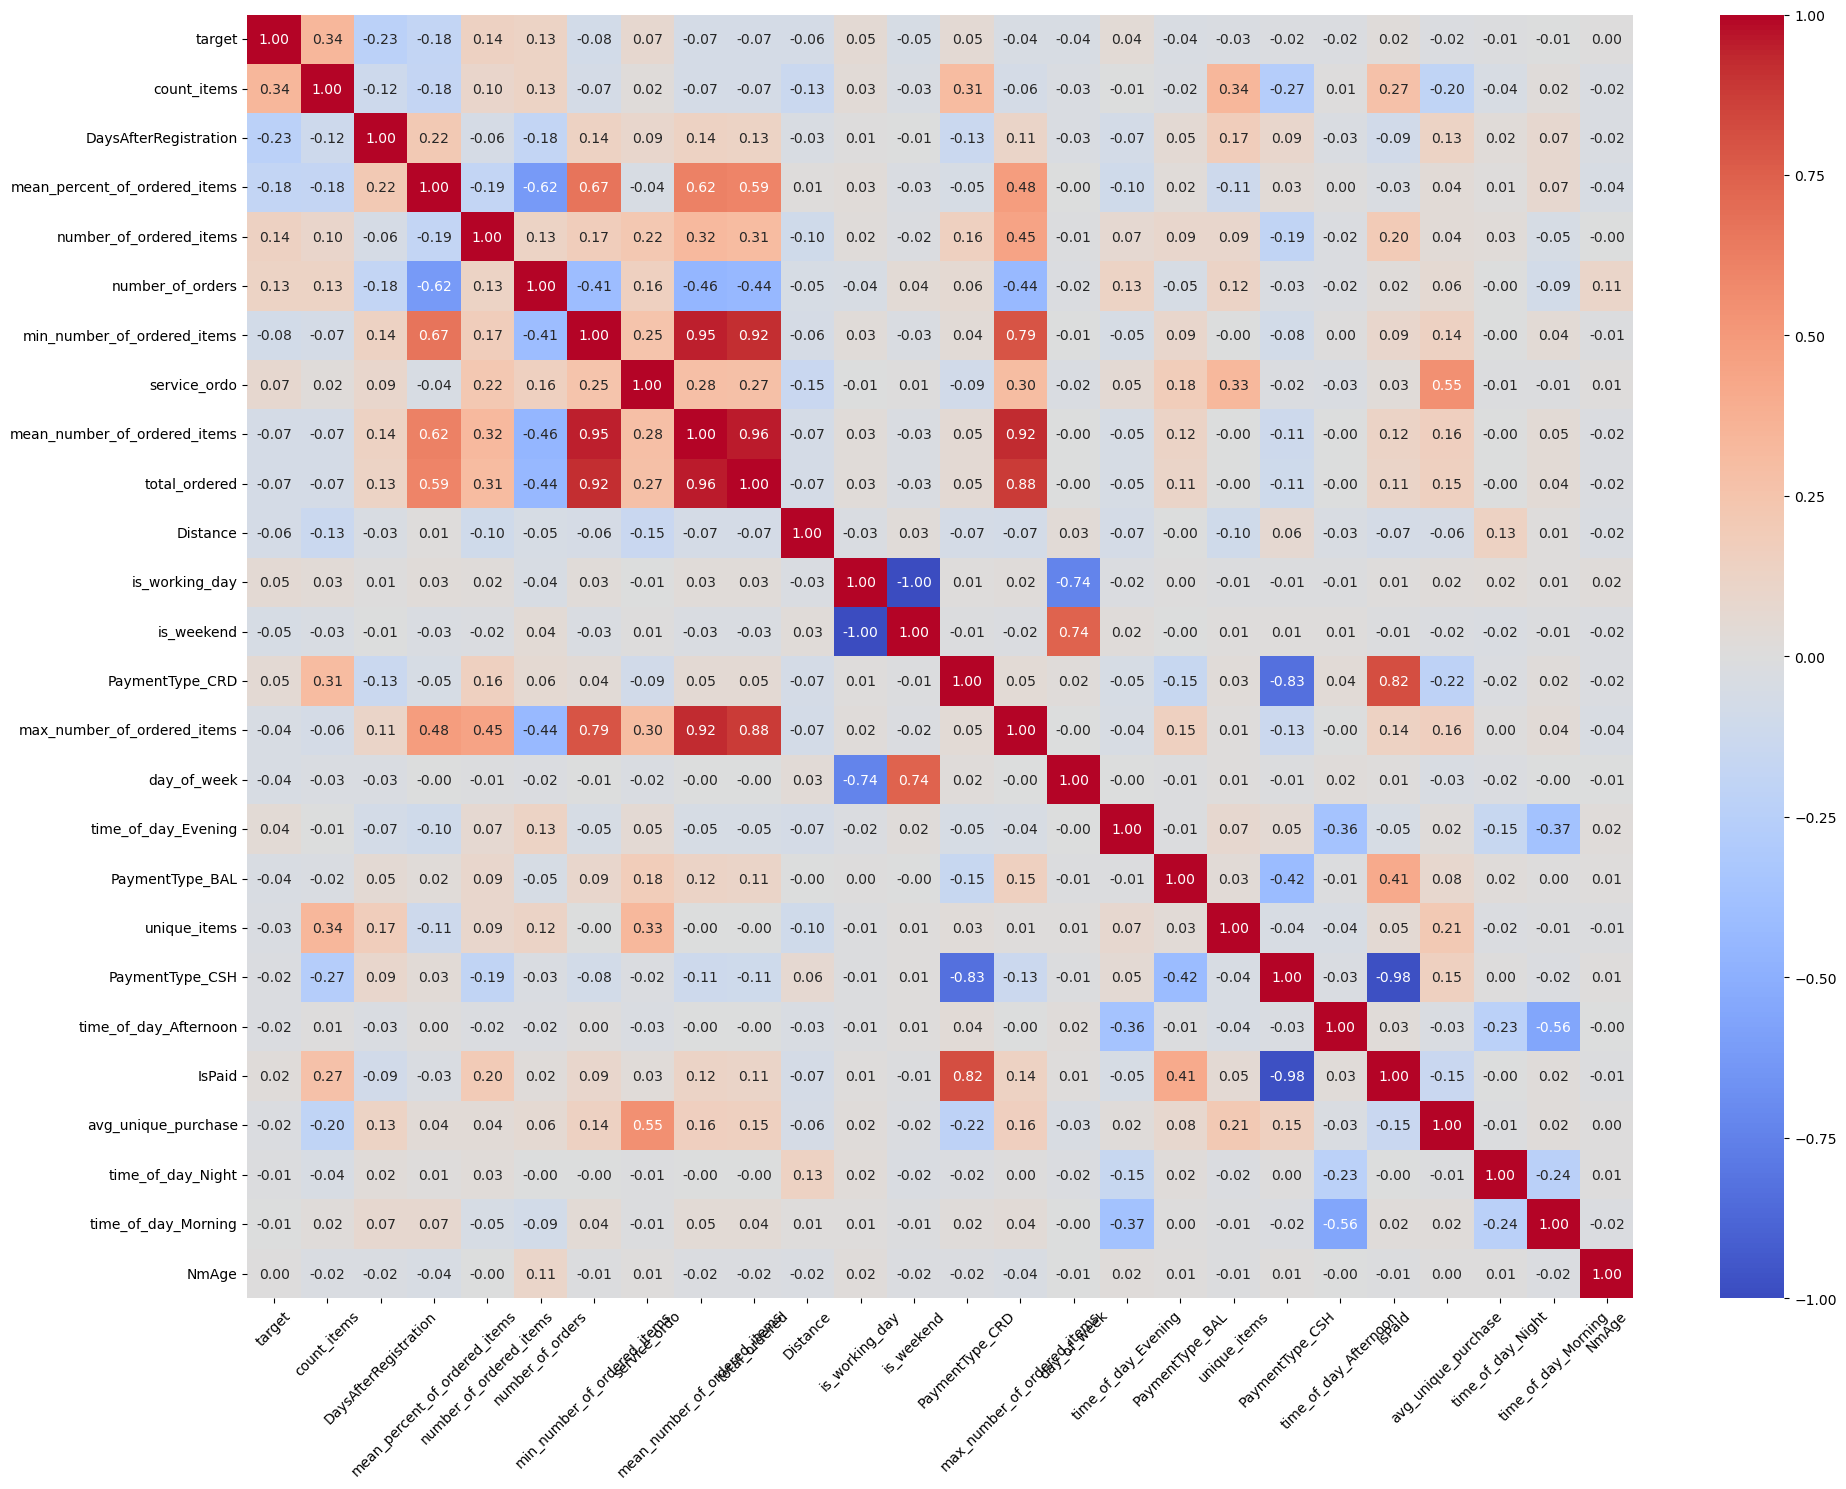

In [119]:

corr_matrix = create_corr_matrix(train_dataset)
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [120]:
train_dataset_logr_antimul = train_dataset.drop(['number_of_orders', 'min_number_of_ordered_items', 'mean_number_of_ordered_items', 'total_ordered', 'max_number_of_ordered_items', 'PaymentType_CRD', 'PaymentType_BAL', 'time_of_day_Night', 'time_of_day_Morning', 'is_working_day', 'time_of_day_Evening', 'day_of_week', 'service_ordo', 'avg_unique_purchase', 'count_items', 'PaymentType_CSH'], axis = 1)
val_dataset_logr_antimul = val_dataset.drop(['number_of_orders', 'min_number_of_ordered_items', 'mean_number_of_ordered_items', 'total_ordered', 'max_number_of_ordered_items', 'PaymentType_CRD', 'PaymentType_BAL', 'time_of_day_Night', 'time_of_day_Morning', 'is_working_day', 'time_of_day_Evening', 'day_of_week', 'service_ordo', 'avg_unique_purchase', 'count_items', 'PaymentType_CSH'], axis = 1)
test_dataset_logr_antimul = test_for_model.drop(['number_of_orders', 'min_number_of_ordered_items', 'mean_number_of_ordered_items', 'total_ordered', 'max_number_of_ordered_items', 'PaymentType_CRD', 'PaymentType_BAL', 'time_of_day_Night', 'time_of_day_Morning', 'is_working_day', 'time_of_day_Evening', 'day_of_week', 'service_ordo', 'avg_unique_purchase', 'count_items', 'PaymentType_CSH'], axis = 1)

In [121]:
train_dataset_logr_antimul

IsPaid  unique_items  NmAge  Distance  DaysAfterRegistration  \
23669        1            38    665      3987                   2519   
100139       0            16  20075      1998                   1518   
17182        0            41  20037      2278                    830   
47740        1           121     39       532                   2072   
101186       0            43     80       466                    401   
...        ...           ...    ...       ...                    ...   
28216        0            41  20034       313                   2728   
100495       0            16    115       782                   3567   
52222        0             0    284      3774                    480   
79936        0            19    147        61                   1268   
6625         0            12    135      3224                    736   

        number_of_ordered_items  mean_percent_of_ordered_items  is_weekend  \
23669                       100                      50.000000           1   
100139                      148                       1.052632           0   
17182                        60                     100.000000           1   
47740                        64                      33.333333           0   
101186                       90                       1.111111           0   
...                         ...                            ...         ...   
28216                        50                     100.000000           0   
100495                       43                       2.325581           0   
52222                        51                      16.666667           0   
79936                        27                       3.703704           0   
6625                        100                     100.000000           0   

        time_of_day_Afternoon  target  
23669                       0       0  
100139                      0       0  
17182                       0       0  
47740                       0       1  
101186                      0       1  
...                       ...     ...  
28216                       1       0  
100495                      0       1  
52222                       0       1  
79936                       0       0  
6625                        0       0  

[73129 rows x 10 columns]

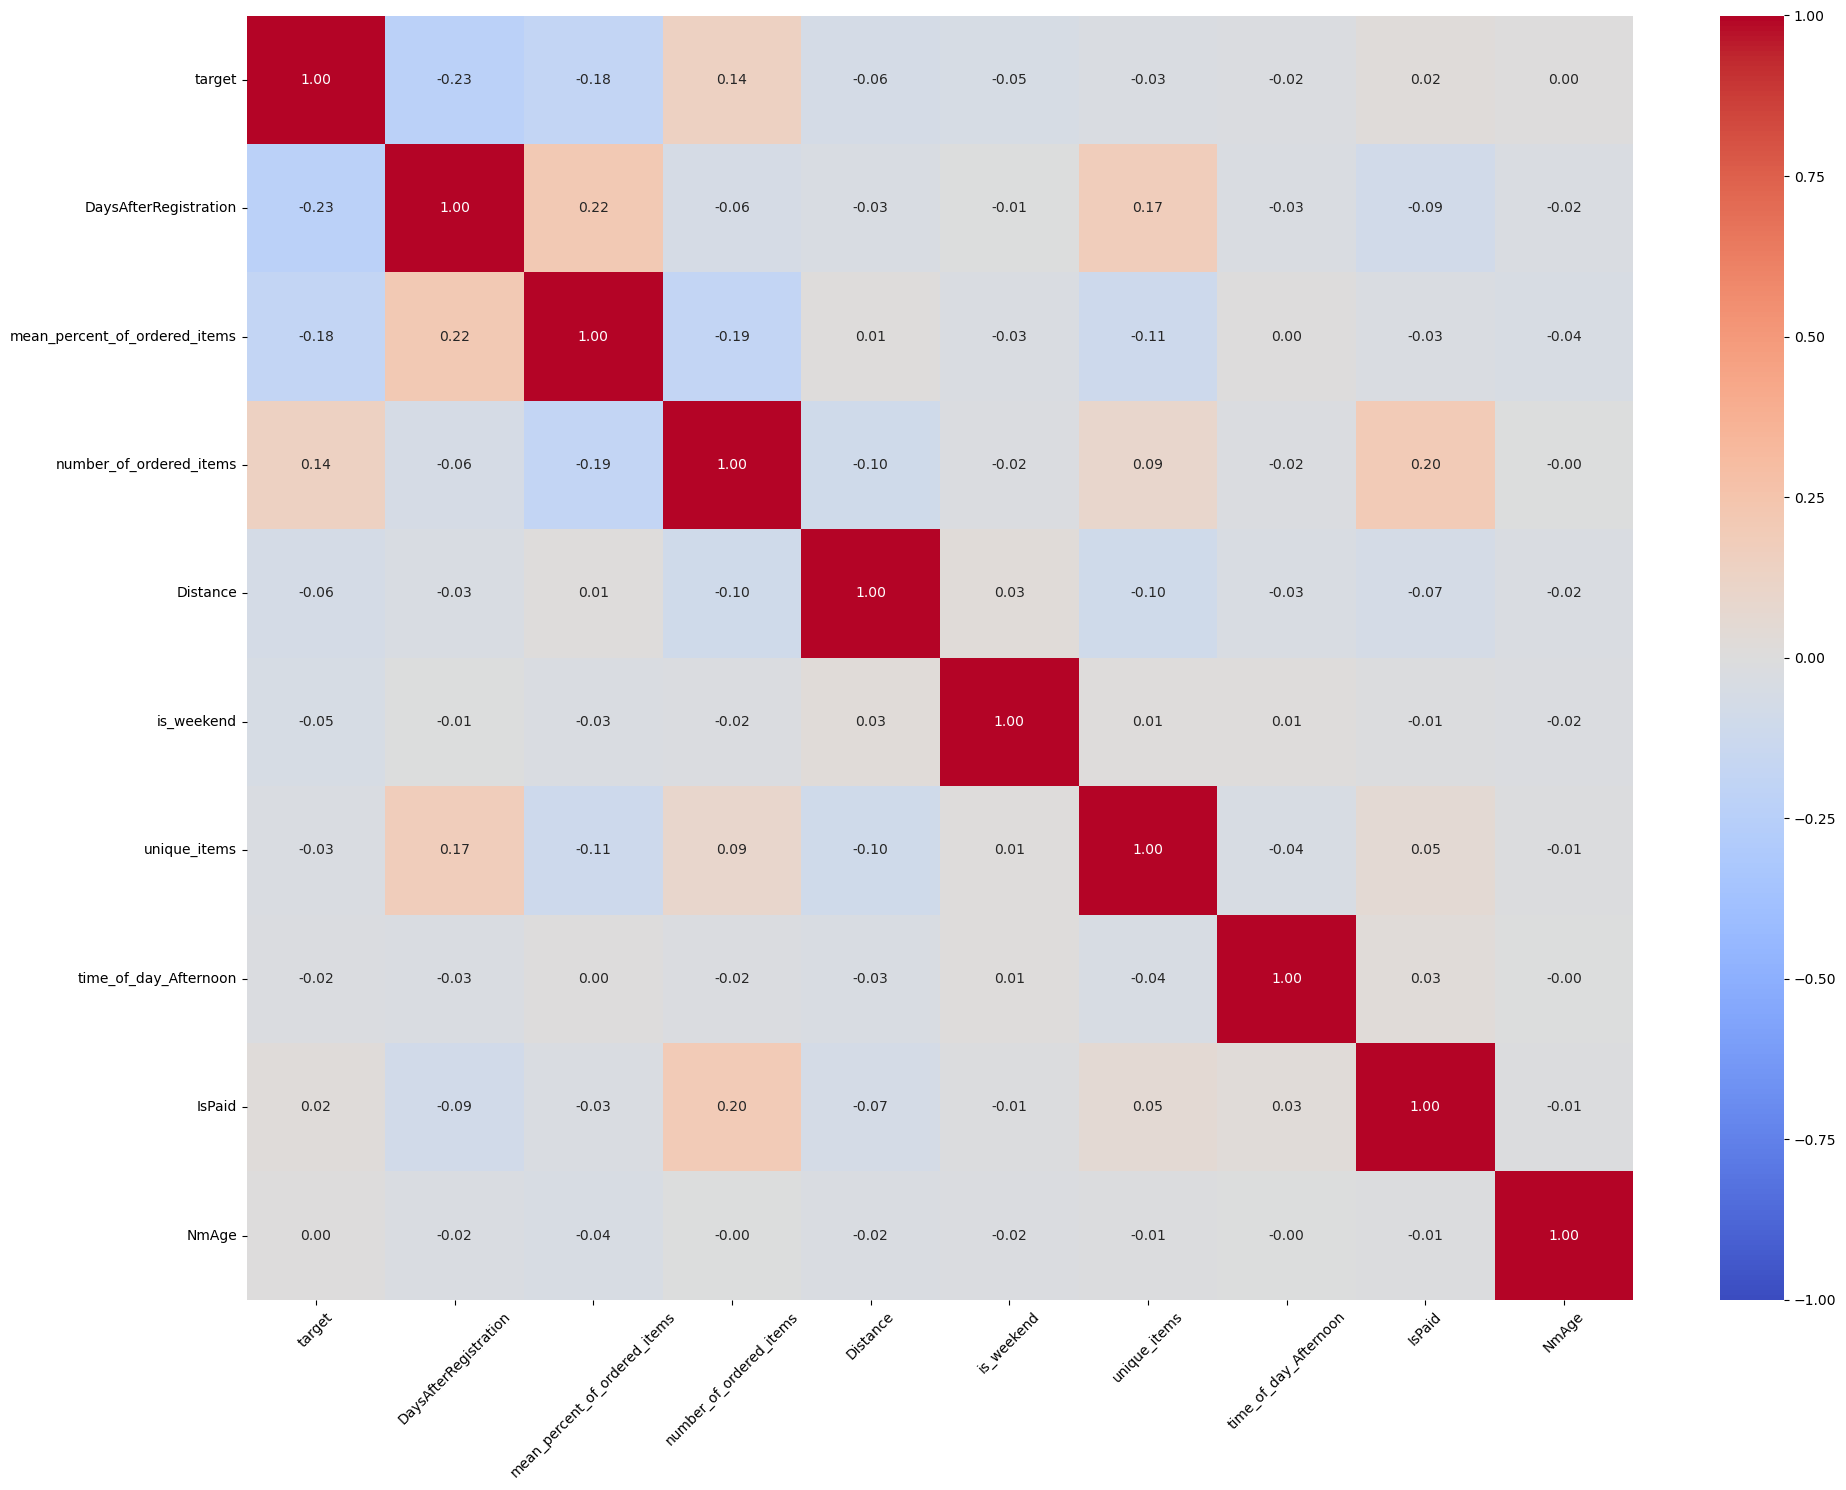

In [122]:
corr_matrix = create_corr_matrix(train_dataset_logr_antimul)
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [123]:
#объединим обратно для работы функции
train_dataset_logr_antimul_for_model = pd.concat([train_dataset_logr_antimul, val_dataset_logr_antimul], axis=0)

In [124]:
X_train_logr_antimul = train_dataset_logr_antimul_for_model.drop(['target'], axis = 1)
y_train_logr_antimul = train_dataset_logr_antimul_for_model['target']

numeric_features = [
    'DaysAfterRegistration', 'mean_percent_of_ordered_items', 'unique_items', 'NmAge', 'Distance', 'number_of_ordered_items']

best_model_logr_antimul, optimal_threshold_logr_antimul, coef_table_logr_antimul = create_optimal_logr(X_train_logr_antimul, y_train_logr_antimul, numeric_features)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Лучшие параметры: {'classifier__C': 1, 'classifier__max_iter': 500, 'classifier__penalty': 'l1'}
Лучший ROC-AUC: 0.7954277001800015
Оптимальный порог: 0.612

Оценка с порогом 0.612:
ROC-AUC: 0.8000
Confusion Matrix:
 [[13536  2636]
 [  748  1363]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.84      0.89     16172
           1       0.34      0.65      0.45      2111

    accuracy                           0.81     18283
   macro avg       0.64      0.74      0.67     18283
weighted avg       0.88      0.81      0.84     18283

                         Признак  Coefficient
0                         IsPaid    -0.875233
6  mean_percent_of_ordered_items    -0.513195
5        number_of_ordered_items     0.423032
1                   unique_items    -0.416725
7                     is_weekend    -0.361064
4          DaysAfterRegistration    -0.242063
8          time_of

In [125]:
best_model_logr_antimul[1].coef_

array([[-0.87523338, -0.41672546,  0.01334859, -0.01364117, -0.24206344,
         0.4230316 , -0.51319451, -0.36106442, -0.18911447]])

In [126]:
test_metrics_logr_antimul = evaluate_model(best_model_logr_antimul, test_dataset_logr_antimul.drop('target', axis=1), test_dataset_logr_antimul['target'], optimal_threshold_logr_antimul)


Оценка с порогом 0.612:
ROC-AUC: 0.6906
Confusion Matrix:
 [[9993 2462]
 [ 983  823]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.80      0.85     12455
           1       0.25      0.46      0.32      1806

    accuracy                           0.76     14261
   macro avg       0.58      0.63      0.59     14261
weighted avg       0.83      0.76      0.79     14261



Показатель ROC-AUC улучшился на 1% на тесте

На 0.003 улучшился показатель ROC-AUC, но прирост мал. Попробуем добавить нелинейности в признаки

In [127]:
test_dataset_logr_antimul

IsPaid  unique_items  NmAge  Distance  DaysAfterRegistration  \
0       False             0    114       913                   1078   
1       False            33    143       105                   2792   
2        True             0    578        94                     29   
3       False             9   1928      1849                   1349   
4       False             0     43      2331                   2168   
...       ...           ...    ...       ...                    ...   
14256    True            73    924       120                   1804   
14257   False             1    214       518                    960   
14258   False             1    214       518                    960   
14259   False             1    214       518                    960   
14260   False             0   1762      1430                      0   

       number_of_ordered_items  mean_percent_of_ordered_items  target  \
0                          854                     100.000000       1   
1                         1062                      20.000000       0   
2                          472                     100.000000       1   
3                          440                     100.000000       0   
4                          400                     100.000000       0   
...                        ...                            ...     ...   
14256                       67                       6.666667       0   
14257                       60                       2.083333       1   
14258                       60                       2.083333       1   
14259                       60                       2.083333       1   
14260                       64                      50.000000       1   

       is_weekend  time_of_day_Afternoon  
0               1                   True  
1               1                  False  
2               0                   True  
3               1                   True  
4               0                  False  
...           ...                    ...  
14256           0                   True  
14257           0                   True  
14258           0                   True  
14259           0                   True  
14260           1                  False  

[14261 rows x 10 columns]

## Логистическая регрессия с добавлением нелинейности в признаках

In [128]:
from sklearn.preprocessing import PolynomialFeatures
train_X_poly, val_X_poly, train_y_poly, val_y_poly = train_test_split(X_train_logr_antimul, y_train_logr_antimul, random_state = 15, test_size = 0.2, shuffle = True, stratify = y_train_logr_antimul) 
poly_features_train = train_X_poly[['DaysAfterRegistration', 'number_of_ordered_items', 'mean_percent_of_ordered_items', 'Distance', 'unique_items']]
poly_features_val = val_X_poly[['DaysAfterRegistration', 'number_of_ordered_items', 'mean_percent_of_ordered_items', 'Distance', 'unique_items']]
poly_features_test = test_dataset_logr_antimul[['DaysAfterRegistration', 'number_of_ordered_items', 'mean_percent_of_ordered_items', 'Distance', 'unique_items']]


poly_transformer = PolynomialFeatures(degree = 2, include_bias=False) #Не добавляем биас, так как автоматичски добавляется при использовании LogisticRegression


poly_transformer.fit(poly_features_train)

poly_features_train = poly_transformer.transform(poly_features_train)
poly_features_val = poly_transformer.transform(poly_features_val)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features_train.shape)

Polynomial Features shape:  (73129, 20)


In [129]:
poly_features_train = pd.DataFrame(poly_features_train, 
                             columns = poly_transformer.get_feature_names_out(['DaysAfterRegistration', 'number_of_ordered_items', 'mean_percent_of_ordered_items', 'Distance', 'unique_items']))
poly_features_train.index = train_X_poly.index

poly_features_train['target'] = train_y_poly
poly_features_train.head(10)

poly_corrs = poly_features_train.corr()['target'].sort_values(key = lambda x: np.abs(x), ascending = False)
poly_corrs.head(30)


target                                                   1.000000
DaysAfterRegistration                                   -0.235030
DaysAfterRegistration mean_percent_of_ordered_items     -0.195633
mean_percent_of_ordered_items                           -0.182061
mean_percent_of_ordered_items^2                         -0.164905
DaysAfterRegistration^2                                 -0.162328
DaysAfterRegistration Distance                          -0.152519
number_of_ordered_items                                  0.143837
mean_percent_of_ordered_items Distance                  -0.121331
number_of_ordered_items^2                                0.114090
mean_percent_of_ordered_items unique_items              -0.100433
DaysAfterRegistration unique_items                      -0.092058
number_of_ordered_items Distance                         0.066084
number_of_ordered_items mean_percent_of_ordered_items   -0.064335
Distance                                                -0.061815
Distance u

In [130]:
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names_out(['DaysAfterRegistration', 'number_of_ordered_items', 'mean_percent_of_ordered_items', 'Distance', 'unique_items']))

poly_features_val = pd.DataFrame(poly_features_val, 
                                  columns = poly_transformer.get_feature_names_out(['DaysAfterRegistration', 'number_of_ordered_items', 'mean_percent_of_ordered_items', 'Distance', 'unique_items']))

poly_features_train.index = train_X_poly.index
poly_features_val.index = val_X_poly.index
poly_features_test.index = test_dataset_logr_antimul.index
poly_features_val['target'] = val_y_poly
poly_features_test['target'] = test_dataset_logr_antimul['target']

train_poly = pd.concat([train_X_poly.drop(['DaysAfterRegistration', 'number_of_ordered_items', 'mean_percent_of_ordered_items', 'Distance', 'unique_items'], axis = 1), 
              poly_features_train], axis=1)
val_poly = pd.concat([val_X_poly.drop(['DaysAfterRegistration', 'number_of_ordered_items', 'mean_percent_of_ordered_items', 'Distance', 'unique_items'], axis = 1), 
              poly_features_val], axis=1)
test_poly = pd.concat([test_dataset_logr_antimul.drop(['DaysAfterRegistration', 'number_of_ordered_items', 'mean_percent_of_ordered_items', 'Distance', 'unique_items', 'target'], axis = 1), 
              poly_features_test], axis=1)

train_poly, val_poly = train_poly.align(val_poly, join = 'inner', axis = 1)
train_poly, test_poly = train_poly.align(test_poly, join = 'inner', axis = 1)

print('Training data with polynomial features shape: ', train_poly.shape)
print('Validation data with polynomial features shape: ', val_poly.shape)
print('Testing data with polynomial features shape:  ', test_poly.shape)

Training data with polynomial features shape:  (73129, 25)
Validation data with polynomial features shape:  (18283, 25)
Testing data with polynomial features shape:   (14261, 25)


Попробьуем отобрать наиболее важные признаки из полученных с помощью регуляризации Лассо

In [131]:
train_poly.columns

Index(['IsPaid', 'NmAge', 'is_weekend', 'time_of_day_Afternoon',
       'DaysAfterRegistration', 'number_of_ordered_items',
       'mean_percent_of_ordered_items', 'Distance', 'unique_items',
       'DaysAfterRegistration^2',
       'DaysAfterRegistration number_of_ordered_items',
       'DaysAfterRegistration mean_percent_of_ordered_items',
       'DaysAfterRegistration Distance', 'DaysAfterRegistration unique_items',
       'number_of_ordered_items^2',
       'number_of_ordered_items mean_percent_of_ordered_items',
       'number_of_ordered_items Distance',
       'number_of_ordered_items unique_items',
       'mean_percent_of_ordered_items^2',
       'mean_percent_of_ordered_items Distance',
       'mean_percent_of_ordered_items unique_items', 'Distance^2',
       'Distance unique_items', 'unique_items^2', 'target'],
      dtype='object')

In [132]:
from sklearn.linear_model import LassoCV
selected_features = []
for seed in range(5):
    lasso = LassoCV(cv=5, random_state=seed)
    lasso.fit(train_poly.drop(['target'], axis=1), train_poly['target'])
    selected_features.append(set(train_poly.drop(['target'], axis=1).columns[lasso.coef_ != 0]))
# Выбираем признаки, появляющиеся во всех запусках
stable_features = set.intersection(*selected_features)
print(stable_features)

{'mean_percent_of_ordered_items Distance', 'DaysAfterRegistration mean_percent_of_ordered_items', 'DaysAfterRegistration^2', 'number_of_ordered_items^2', 'Distance^2', 'DaysAfterRegistration number_of_ordered_items', 'DaysAfterRegistration Distance', 'number_of_ordered_items Distance', 'DaysAfterRegistration unique_items'}


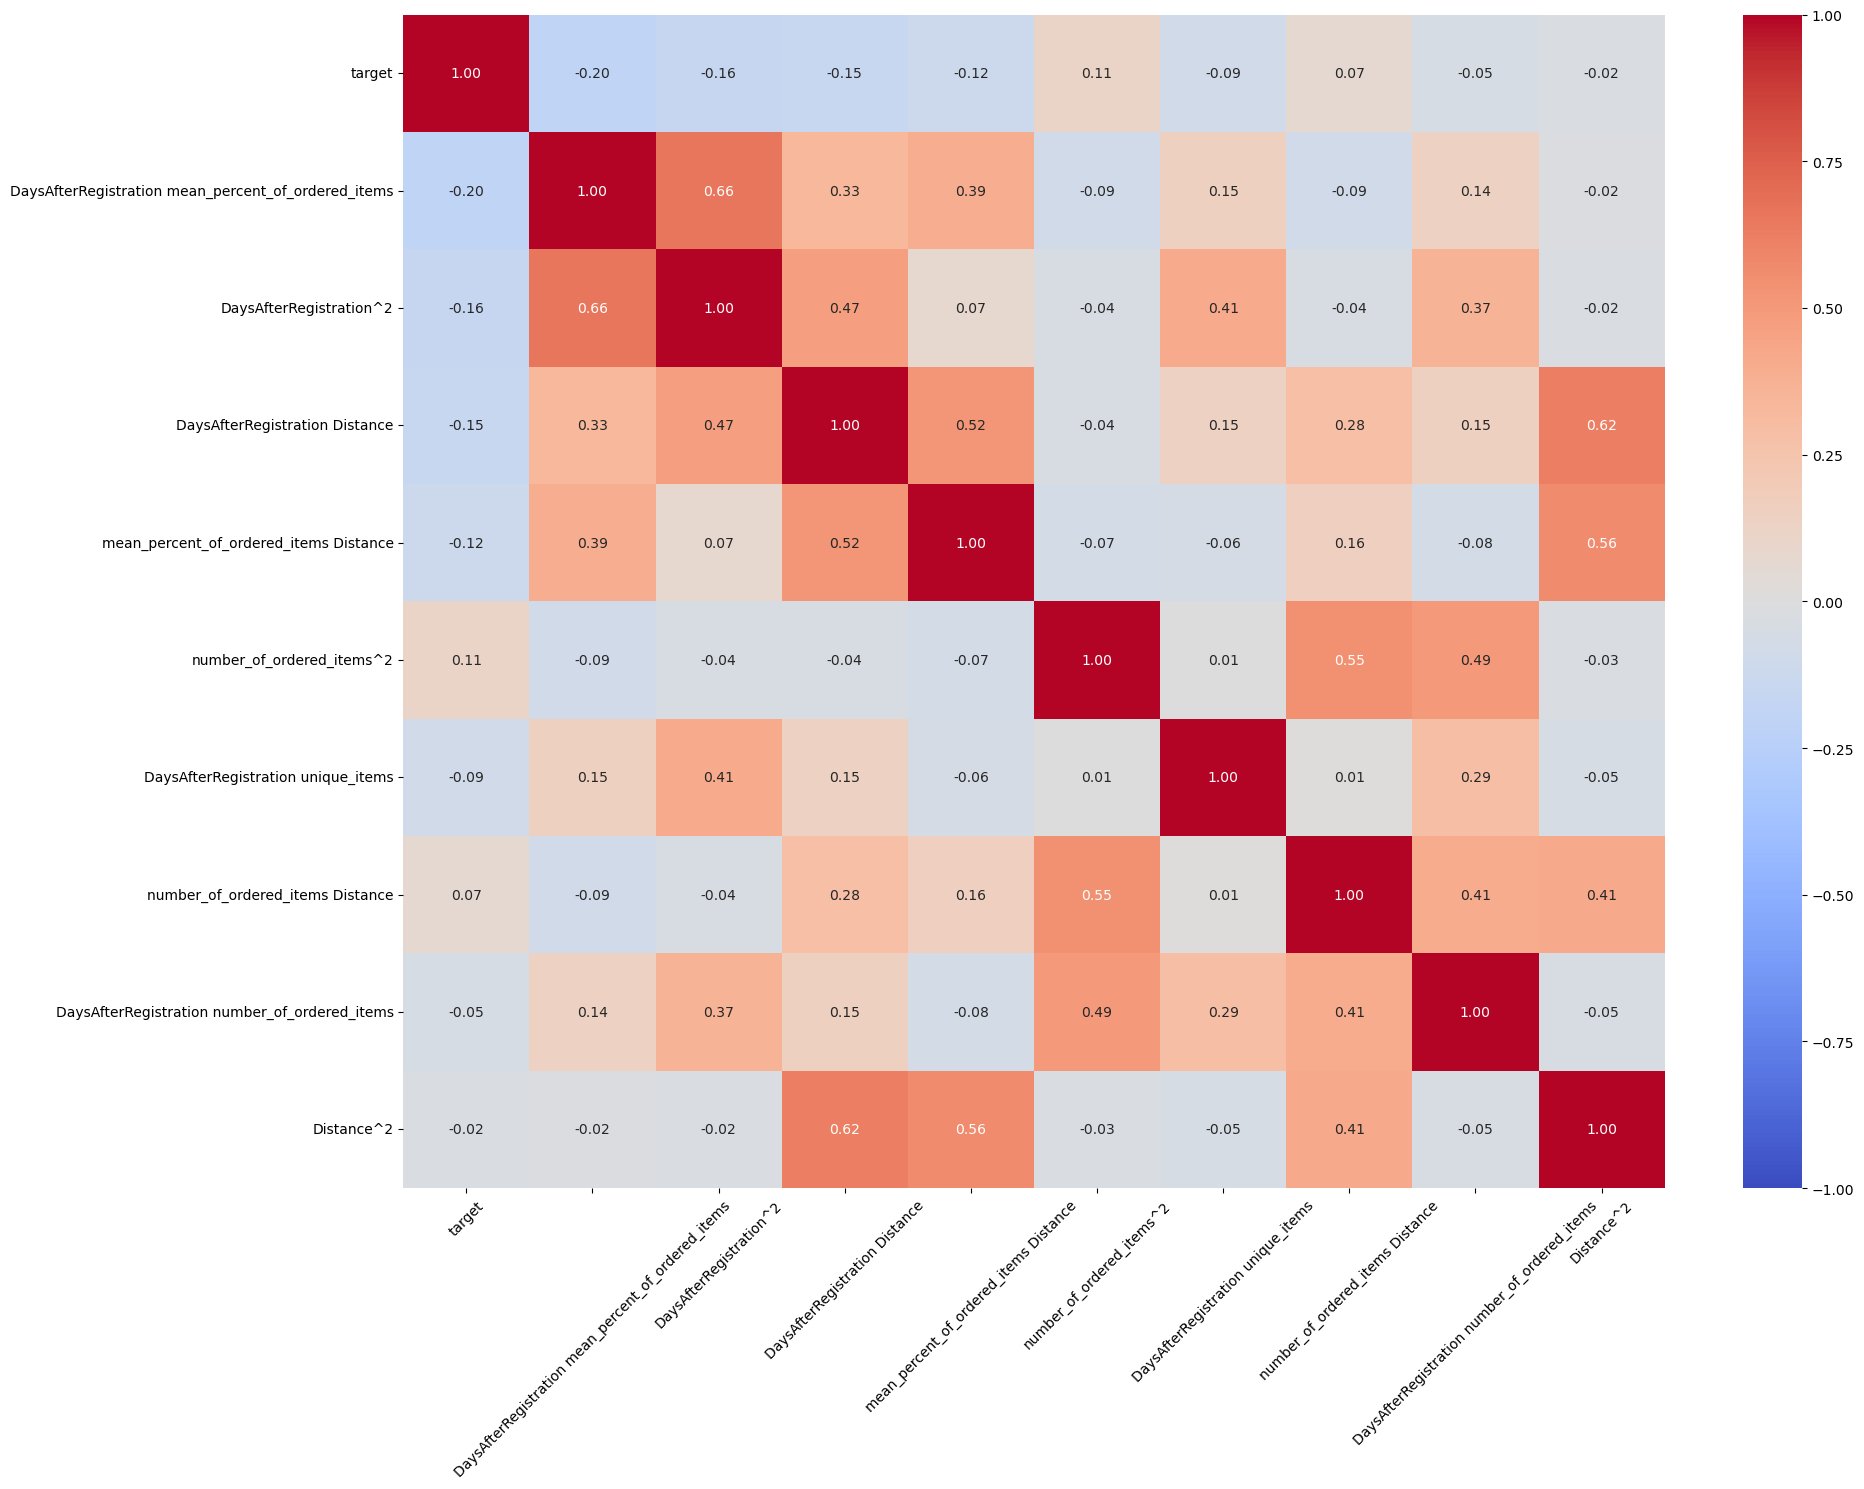

In [133]:
corr_matrix = create_corr_matrix(train_poly[['DaysAfterRegistration^2', 'DaysAfterRegistration Distance', 'DaysAfterRegistration unique_items', 'Distance^2', 'number_of_ordered_items Distance', 'mean_percent_of_ordered_items Distance', 'number_of_ordered_items^2', 'DaysAfterRegistration number_of_ordered_items', 'DaysAfterRegistration mean_percent_of_ordered_items', 'target']])
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Полученные признаки несильно коррелируют друг с другом, поэтому можно обучить модель на отобранных признаках

In [134]:
train_for_model_poly = train_poly[['DaysAfterRegistration^2', 'DaysAfterRegistration Distance', 'DaysAfterRegistration unique_items', 'Distance^2', 'number_of_ordered_items Distance', 'mean_percent_of_ordered_items Distance', 'number_of_ordered_items^2', 'DaysAfterRegistration number_of_ordered_items', 'DaysAfterRegistration mean_percent_of_ordered_items', 'target']]
val_for_model_poly = val_poly[['DaysAfterRegistration^2', 'DaysAfterRegistration Distance', 'DaysAfterRegistration unique_items', 'Distance^2', 'number_of_ordered_items Distance', 'mean_percent_of_ordered_items Distance', 'number_of_ordered_items^2', 'DaysAfterRegistration number_of_ordered_items', 'DaysAfterRegistration mean_percent_of_ordered_items', 'target']]
test_for_model_poly = test_poly[['DaysAfterRegistration^2', 'DaysAfterRegistration Distance', 'DaysAfterRegistration unique_items', 'Distance^2', 'number_of_ordered_items Distance', 'mean_percent_of_ordered_items Distance', 'number_of_ordered_items^2', 'DaysAfterRegistration number_of_ordered_items', 'DaysAfterRegistration mean_percent_of_ordered_items', 'target']]
train_dataset_for_model_poly = pd.concat([train_for_model_poly, val_for_model_poly], axis = 0)

In [135]:
X_train_logr_poly = train_dataset_for_model_poly.drop(['target'], axis = 1)
y_train_logr_poly = train_dataset_for_model_poly['target']

numeric_features = ['DaysAfterRegistration^2', 'DaysAfterRegistration Distance', 'DaysAfterRegistration unique_items', 'Distance^2', 'number_of_ordered_items Distance', 'mean_percent_of_ordered_items Distance', 'number_of_ordered_items^2', 'DaysAfterRegistration number_of_ordered_items', 'DaysAfterRegistration mean_percent_of_ordered_items']

best_model_logr_poly, optimal_threshold_logr_poly, feature_table_logr_poly = create_optimal_logr(X_train_logr_poly, y_train_logr_poly, numeric_features)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Лучшие параметры: {'classifier__C': 0.01, 'classifier__max_iter': 100, 'classifier__penalty': 'l1'}
Лучший ROC-AUC: 0.7846780106083656
Оптимальный порог: 0.650

Оценка с порогом 0.650:
ROC-AUC: 0.7842
Confusion Matrix:
 [[13988  2184]
 [  961  1150]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90     16172
           1       0.34      0.54      0.42      2111

    accuracy                           0.83     18283
   macro avg       0.64      0.70      0.66     18283
weighted avg       0.87      0.83      0.84     18283

                                             Признак  Coefficient
0                            DaysAfterRegistration^2    -0.736008
8  DaysAfterRegistration mean_percent_of_ordered_...    -0.414497
6                          number_of_ordered_items^2     0.274445
5             mean_percent_of_ordered_items Distance    -0.154024
7      

In [136]:
test_metrics_logr_poly = evaluate_model(best_model_logr_poly, test_for_model_poly.drop('target', axis=1), test_for_model_poly['target'], optimal_threshold_logr_poly)


Оценка с порогом 0.650:
ROC-AUC: 0.7148
Confusion Matrix:
 [[10404  2051]
 [ 1087   719]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87     12455
           1       0.26      0.40      0.31      1806

    accuracy                           0.78     14261
   macro avg       0.58      0.62      0.59     14261
weighted avg       0.82      0.78      0.80     14261



Проверим какой получится результат, если оставить все созданные признаки

In [137]:
train_dataset_for_model_poly_all_features = pd.concat([train_poly, val_poly], axis = 0)

X_train_logr_poly_all_features = train_dataset_for_model_poly_all_features.drop('target', axis = 1)
y_train_logr_poly_all_features = train_dataset_for_model_poly_all_features['target']

numeric_features = ['DaysAfterRegistration^2', 'DaysAfterRegistration Distance', 'DaysAfterRegistration unique_items', 'Distance^2', 'number_of_ordered_items Distance', 'mean_percent_of_ordered_items Distance', 'number_of_ordered_items^2', 'DaysAfterRegistration number_of_ordered_items', 'DaysAfterRegistration mean_percent_of_ordered_items']

best_model_logr_poly_all_features, optimal_threshold_logr_poly_all_features, feature_table_all_features = create_optimal_logr(X_train_logr_poly_all_features, y_train_logr_poly_all_features, numeric_features)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Лучшие параметры: {'classifier__C': 1, 'classifier__max_iter': 1000, 'classifier__penalty': 'l1'}
Лучший ROC-AUC: 0.8133752652394477
Оптимальный порог: 0.679

Оценка с порогом 0.679:
ROC-AUC: 0.8100
Confusion Matrix:
 [[14449  1723]
 [ 1000  1111]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91     16172
           1       0.39      0.53      0.45      2111

    accuracy                           0.85     18283
   macro avg       0.66      0.71      0.68     18283
weighted avg       0.87      0.85      0.86     18283

                                              Признак  Coefficient
3                               time_of_day_Afternoon    -3.458516
0                                              IsPaid    -2.216559
4                               DaysAfterRegistration     1.666575
5                             number_of_ordered_items     0.858405
6   

In [138]:
test_metrics_logr_poly_all_features = evaluate_model(best_model_logr_poly_all_features, test_poly.drop('target', axis=1), test_poly['target'], optimal_threshold_logr_poly_all_features)


Оценка с порогом 0.679:
ROC-AUC: 0.6594
Confusion Matrix:
 [[10664  1791]
 [ 1138   668]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88     12455
           1       0.27      0.37      0.31      1806

    accuracy                           0.79     14261
   macro avg       0.59      0.61      0.60     14261
weighted avg       0.82      0.79      0.81     14261



In [139]:
best_model_logr_poly_all_features[1].intercept_

array([-1.3336328])

Без отбора признаков с помощью регуляризации Лассо, оценка ROC-AUC на тесте стало меньше, чем на базовой модели.
Таким образом при использовании логистической регрессии лучшим датасетом для обучения модели, стал датасет, содержащий полиномиальные признаки, очищенные от излишней мультиколлинеарности. Итоговое значение ROC-AUC на тесте 0.7148

## Случайный лес

Возьмём сэмплы из датасетов, на которых обучались модели логистической регрессии для ускорения обучения и подбора гиперпараметров

In [140]:
train_RF_base = filtered_train
train_RF_antimul = train_dataset_logr_antimul_for_model
train_RF_poly = train_dataset_for_model_poly
train_RF_poly_all = train_dataset_for_model_poly_all_features

In [141]:
train_RF_base_sample = pd.concat((train_RF_base[train_RF_base['target'] == 1].sample(10555, random_state=15), train_RF_base[train_RF_base['target'] == 0].sample(10555, random_state=15)))
train_RF_antimul_sample = pd.concat((train_RF_antimul[train_RF_antimul['target'] == 1].sample(10555, random_state=15), train_RF_antimul[train_RF_antimul['target'] == 0].sample(10555, random_state=15)))
train_RF_poly_sample = pd.concat((train_RF_poly[train_RF_poly['target'] == 1].sample(10555, random_state=15), train_RF_poly[train_RF_poly['target'] == 0].sample(10555, random_state=15)))
train_RF_poly_all_sample = pd.concat((train_RF_poly_all[train_RF_poly_all['target'] == 1].sample(10555, random_state=15), train_RF_poly_all[train_RF_poly_all['target'] == 0].sample(10555, random_state=15)))

In [142]:

def find_optimal_threshold(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba, pos_label=1)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_idx = np.argmax(f1_scores)
    return thresholds[optimal_idx]

def get_coeffs_table(model, df):
    coeffs_logr_table = pd.DataFrame({
    'Признак': df.columns,
    'Coefficient': model.feature_importances_
    }).sort_values(by = 'Coefficient', key=lambda x: np.abs(x), ascending = False)
    print(coeffs_logr_table)
    return coeffs_logr_table

def evaluate_model(model, X, y_true, threshold=0.5):
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    
    print(f"\nОценка с порогом {threshold:.3f}:")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_proba):.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    
    return {
        'roc_auc': roc_auc_score(y_true, y_proba),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'classification_report': classification_report(y_true, y_pred, output_dict=True),
        'y_proba': y_proba,
        'y_pred': y_pred
    }

def create_optimal_RF(X_train_sample, y_train_sample, X_train_all, y_train_all, numeric_features):
    # Разделяем данные на обучающую и валидационную выборки для подбора порога
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('power', PowerTransformer(method='yeo-johnson', standardize=True), numeric_features)
        ],
        remainder='passthrough'
    )
    
    # Создаем и обучаем пайплайн с лучшими параметрами
    pipeline_RF = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            class_weight = 'balanced_subsample'))
    ])

    param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [5, 10, 20, 30],
    'classifier__min_samples_leaf': [5, 10, 15],
    'classifier__max_features': ['sqrt', 'log2']
    }
    
    # Подбираем гиперпараметры
    grid = GridSearchCV(
        pipeline_RF, 
        param_grid, 
        cv=5, 
        scoring='roc_auc', 
        n_jobs=5, 
        verbose=4
    )

    grid.fit(X_train_sample, y_train_sample)
    best_model_sample = grid.best_estimator_

    # Делим датасет на тренировочный и валидационный
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_all, 
        y_train_all, 
        test_size=0.1, 
        random_state=15,
        stratify=y_train_all
    )

    
    # Обучаем на всех данных
    final_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            class_weight='balanced_subsample',
            **{k.replace('classifier__', ''): v for k, v in grid.best_params_.items()}
        ))
    ])
    
    final_pipeline.fit(X_train, y_train)
    
    # Лучшая модель
    print('Лучшие параметры:', grid.best_params_)
    print('Лучший ROC-AUC на сэмплировании:', grid.best_score_)
    print(final_pipeline[1])

    
    # Получаем вероятности на валидационной выборке
    y_val_proba = final_pipeline.predict_proba(X_val)[:, 1]

    # Находим оптимальный порог
    optimal_threshold = find_optimal_threshold(y_val, y_val_proba)
    print(f'Оптимальный порог: {optimal_threshold:.3f}')

    #Метрики на валидации
    val_metrics = evaluate_model(final_pipeline, X_val, y_val, optimal_threshold)

    #Важности признаков
    feature_importances = get_coeffs_table(final_pipeline[1], X_train)
    
    return final_pipeline, optimal_threshold, feature_importances


## Случайный лес базовый датасет

In [143]:
X_train_RF_base_sample = train_RF_base_sample.drop(['target'], axis = 1)
y_train_RF_base_sample = train_RF_base_sample['target']


numeric_features = [
    'total_ordered', 'count_items', 'unique_items', 'avg_unique_purchase',
    'NmAge', 'Distance', 'DaysAfterRegistration', 'number_of_orders',
    'number_of_ordered_items', 'mean_number_of_ordered_items',
    'min_number_of_ordered_items', 'max_number_of_ordered_items',
    'mean_percent_of_ordered_items'
]

best_model_RF_base, optimal_threshold_RF_base, importances_RF_base = create_optimal_RF(X_train_RF_base_sample, y_train_RF_base_sample, train_RF_base.drop(['target'], axis =1), train_RF_base['target'], numeric_features)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Лучшие параметры: {'classifier__max_depth': 7, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 10}
Лучший ROC-AUC на сэмплировании: 0.9445303648457999
RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       min_samples_leaf=5, min_samples_split=10)
Оптимальный порог: 0.623

Оценка с порогом 0.623:
ROC-AUC: 0.9469
Confusion Matrix:
 [[7753  333]
 [ 274  782]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      8086
           1       0.70      0.74      0.72      1056

    accuracy                           0.93      9142
   macro avg       0.83      0.85      0.84      9142
weighted avg       0.94      0.93      0.93      9142

                          Признак  Coefficient
6                        Distance     0.219189
1                          IsPaid     

In [144]:
test_metrics_RF_base = evaluate_model(best_model_RF_base, test_for_model.drop('target', axis=1), test_for_model['target'], optimal_threshold_RF_base)


Оценка с порогом 0.623:
ROC-AUC: 0.6346
Confusion Matrix:
 [[11670   785]
 [ 1293   513]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92     12455
           1       0.40      0.28      0.33      1806

    accuracy                           0.85     14261
   macro avg       0.65      0.61      0.62     14261
weighted avg       0.84      0.85      0.84     14261



## Случайные лес, датасет очищенный

In [145]:
'DaysAfterRegistration', 'mean_percent_of_ordered_items', 'unique_items', 'NmAge', 'Distance', 'number_of_ordered_items', 'mean_percent_of_ordered_items'

('DaysAfterRegistration',
 'mean_percent_of_ordered_items',
 'unique_items',
 'NmAge',
 'Distance',
 'number_of_ordered_items',
 'mean_percent_of_ordered_items')

In [146]:

X_train_RF_antimul = train_RF_antimul_sample.drop('target', axis = 1)
y_train_RF_antimul = train_RF_antimul_sample['target']

numeric_features = ['DaysAfterRegistration', 'mean_percent_of_ordered_items', 'unique_items', 'NmAge', 'Distance', 'number_of_ordered_items'
    ]

best_model_RF_antimul, optimal_threshold_RF_antimul, coef_table_RF_antimul = create_optimal_RF(X_train_RF_antimul, y_train_RF_antimul, train_RF_antimul.drop(['target'], axis=1), train_RF_antimul['target'], numeric_features)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Лучшие параметры: {'classifier__max_depth': 7, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 5}
Лучший ROC-AUC на сэмплировании: 0.921472061819604
RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       max_features='log2', min_samples_leaf=5,
                       min_samples_split=5)
Оптимальный порог: 0.699

Оценка с порогом 0.699:
ROC-AUC: 0.9282
Confusion Matrix:
 [[7849  237]
 [ 391  665]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      8086
           1       0.74      0.63      0.68      1056

    accuracy                           0.93      9142
   macro avg       0.84      0.80      0.82      9142
weighted avg       0.93      0.93      0.93      9142

                         Признак  Coefficient
0                         IsPaid     0.363273

In [147]:
test_metrics_RF_base = evaluate_model(best_model_RF_antimul, test_dataset_logr_antimul.drop('target', axis=1), test_dataset_logr_antimul['target'], optimal_threshold_RF_antimul)


Оценка с порогом 0.699:
ROC-AUC: 0.6482
Confusion Matrix:
 [[11805   650]
 [ 1470   336]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92     12455
           1       0.34      0.19      0.24      1806

    accuracy                           0.85     14261
   macro avg       0.62      0.57      0.58     14261
weighted avg       0.82      0.85      0.83     14261



Качество модели выросло, но всё ещё ниже чем у логистической регрессии

## Случайные лес, датасет с добавленными полиномиальными признаками

In [148]:
train_for_model_poly = train_poly[['DaysAfterRegistration^2', 'DaysAfterRegistration Distance', 'DaysAfterRegistration unique_items', 'Distance^2', 'number_of_ordered_items Distance', 'mean_percent_of_ordered_items Distance', 'number_of_ordered_items^2', 'DaysAfterRegistration number_of_ordered_items', 'DaysAfterRegistration mean_percent_of_ordered_items', 'target']]
val_for_model_poly = val_poly[['DaysAfterRegistration^2', 'DaysAfterRegistration Distance', 'DaysAfterRegistration unique_items', 'Distance^2', 'number_of_ordered_items Distance', 'mean_percent_of_ordered_items Distance', 'number_of_ordered_items^2', 'DaysAfterRegistration number_of_ordered_items', 'DaysAfterRegistration mean_percent_of_ordered_items', 'target']]
test_for_model_poly = test_poly[['DaysAfterRegistration^2', 'DaysAfterRegistration Distance', 'DaysAfterRegistration unique_items', 'Distance^2', 'number_of_ordered_items Distance', 'mean_percent_of_ordered_items Distance', 'number_of_ordered_items^2', 'DaysAfterRegistration number_of_ordered_items', 'DaysAfterRegistration mean_percent_of_ordered_items', 'target']]
train_dataset_for_model_poly = pd.concat([train_for_model_poly, val_for_model_poly], axis = 0)

In [149]:
X_train_RF_poly = train_RF_poly_sample.drop(['target'], axis = 1)
y_train_RF_poly = train_RF_poly_sample['target']

numeric_features = ['DaysAfterRegistration^2', 'DaysAfterRegistration Distance', 'DaysAfterRegistration unique_items', 'Distance^2', 'number_of_ordered_items Distance', 'mean_percent_of_ordered_items Distance', 'number_of_ordered_items^2', 'DaysAfterRegistration number_of_ordered_items', 'DaysAfterRegistration mean_percent_of_ordered_items']

best_model_RF_poly, optimal_threshold_RF_poly, feature_table_RF_poly = create_optimal_RF(X_train_RF_poly, y_train_RF_poly, train_RF_poly.drop(['target'], axis=1), train_RF_poly['target'], numeric_features)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Лучшие параметры: {'classifier__max_depth': 7, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 5}
Лучший ROC-AUC на сэмплировании: 0.911081001570578
RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       max_features='log2', min_samples_leaf=5,
                       min_samples_split=5)
Оптимальный порог: 0.705

Оценка с порогом 0.705:
ROC-AUC: 0.9155
Confusion Matrix:
 [[7857  229]
 [ 384  672]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      8086
           1       0.75      0.64      0.69      1056

    accuracy                           0.93      9142
   macro avg       0.85      0.80      0.82      9142
weighted avg       0.93      0.93      0.93      9142

                                             Признак  Coefficient
0                        

In [150]:
test_metrics_RF_poly = evaluate_model(best_model_RF_poly, test_for_model_poly.drop('target', axis=1), test_for_model_poly['target'], optimal_threshold_RF_poly)


Оценка с порогом 0.705:
ROC-AUC: 0.6537
Confusion Matrix:
 [[11730   725]
 [ 1515   291]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91     12455
           1       0.29      0.16      0.21      1806

    accuracy                           0.84     14261
   macro avg       0.59      0.55      0.56     14261
weighted avg       0.81      0.84      0.82     14261



На всех полиномиальных данных

In [151]:

X_train_RF_poly_all_features = train_RF_poly_all_sample.drop('target', axis = 1)
y_train_RF_poly_all_features = train_RF_poly_all_sample['target']

numeric_features = ['DaysAfterRegistration^2', 'DaysAfterRegistration Distance', 'DaysAfterRegistration unique_items', 'Distance^2', 'number_of_ordered_items Distance', 'mean_percent_of_ordered_items Distance', 'number_of_ordered_items^2', 'DaysAfterRegistration number_of_ordered_items', 'DaysAfterRegistration mean_percent_of_ordered_items']

best_model_RF_poly_all_features, optimal_threshold_RF_poly_all_features, feature_table_RF_all_features = create_optimal_RF(X_train_RF_poly_all_features, y_train_RF_poly_all_features, train_RF_poly_all.drop(['target'], axis =1), train_RF_poly_all['target'], numeric_features)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Лучшие параметры: {'classifier__max_depth': 7, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 5}
Лучший ROC-AUC на сэмплировании: 0.9242845163084079
RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       max_features='log2', min_samples_leaf=5,
                       min_samples_split=5)
Оптимальный порог: 0.700

Оценка с порогом 0.700:
ROC-AUC: 0.9249
Confusion Matrix:
 [[7872  214]
 [ 358  698]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      8086
           1       0.77      0.66      0.71      1056

    accuracy                           0.94      9142
   macro avg       0.86      0.82      0.84      9142
weighted avg       0.93      0.94      0.94      9142

                                              Признак  Coefficient
8                      

In [152]:
test_metrics_RF_poly_all_features = evaluate_model(best_model_RF_poly_all_features, test_poly.drop('target', axis=1), test_poly['target'], optimal_threshold_RF_poly_all_features)


Оценка с порогом 0.700:
ROC-AUC: 0.6792
Confusion Matrix:
 [[11781   674]
 [ 1412   394]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92     12455
           1       0.37      0.22      0.27      1806

    accuracy                           0.85     14261
   macro avg       0.63      0.58      0.60     14261
weighted avg       0.83      0.85      0.84     14261



Модель с использованием случайного леса показала немного худший результат, чем логистическая регрессия. Попробуем совместить модели в одну, используя блендинг

## Blending

In [153]:

class ModelBlender:
    def __init__(self, models, weights=[0.5, 0.5]):
        self.models = models
        self.weights = weights if weights else [1/len(models)] * len(models)
        
    def predict_proba(self, X):
        probas = [model.predict_proba(X) for model in self.models]
        blended_proba = np.zeros_like(probas[0])
            
        for i, proba in enumerate(probas):
            blended_proba += self.weights[i] * proba
        return blended_proba
    
    def predict(self, X, threshold=0.5, is_courier = False):
        blended_proba = self.predict_proba(X)
        predictions = (blended_proba[:, 1] >= threshold).astype(int)
        
        if is_courier:
            courier_mask = X['is_courier'] == 1
            if courier_mask.any():
                predictions[courier_mask] = 0
                
        return predictions

    def evaluate(self, X, y, threshold=0.5, is_courier = False):
        
        # Получаем предсказания
        y_pred_proba = self.predict_proba(X)[:, 1]
        y_pred = self.predict(X, threshold, is_courier)
        
        # Вычисляем метрики
        metrics_dict = {
            'roc_auc': roc_auc_score(y, y_pred_proba),
            'accuracy': accuracy_score(y, y_pred),
            'precision': precision_score(y, y_pred, zero_division=0),
            'recall': recall_score(y, y_pred),
            'f1': f1_score(y, y_pred),
            'average_precision': average_precision_score(y, y_pred_proba),
            'confusion_matrix': confusion_matrix(y, y_pred),
            'classification_report': classification_report(y, y_pred)
        }

        """Печать метрик в читаемом формате"""
        print("=" * 50)
        print("МЕТРИКИ КАЧЕСТВА МОДЕЛИ")
        print("=" * 50)
        print(f"ROC-AUC: {metrics_dict['roc_auc']:.4f}")
        print(f"Accuracy: {metrics_dict['accuracy']:.4f}")
        print(f"Precision: {metrics_dict['precision']:.4f}")
        print(f"Recall: {metrics_dict['recall']:.4f}")
        print(f"F1-score: {metrics_dict['f1']:.4f}")
        print(f"Average Precision: {metrics_dict['average_precision']:.4f}")
        print("\nМатрица ошибок:")
        print(metrics_dict['confusion_matrix'])
        print("Classification Report:\n", classification_report(y, y_pred))


Базовые модели и датасеты

In [154]:
Logr_RF_base = ModelBlender([best_model_logr_base,best_model_RF_base], weights = [0.55, 0.45])

In [155]:
Logr_RF_base.evaluate(test_for_model.drop('target', axis=1), test_for_model['target'], (optimal_threshold_logr_base + optimal_threshold_RF_base)/2)

МЕТРИКИ КАЧЕСТВА МОДЕЛИ
ROC-AUC: 0.6865
Accuracy: 0.8213
Precision: 0.3227
Recall: 0.3738
F1-score: 0.3463
Average Precision: 0.2594

Матрица ошибок:
[[11038  1417]
 [ 1131   675]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90     12455
           1       0.32      0.37      0.35      1806

    accuracy                           0.82     14261
   macro avg       0.61      0.63      0.62     14261
weighted avg       0.83      0.82      0.83     14261



Модели и датасеты с учтранением скоррелированных признаков

In [156]:
LOGR_RF_antimul = ModelBlender([best_model_logr_antimul,best_model_RF_antimul], weights = [0.55, 0.45])

In [157]:
LOGR_RF_antimul.evaluate(test_dataset_logr_antimul.drop('target', axis=1), test_dataset_logr_antimul['target'], (optimal_threshold_logr_antimul+optimal_threshold_RF_antimul)/2)

МЕТРИКИ КАЧЕСТВА МОДЕЛИ
ROC-AUC: 0.6929
Accuracy: 0.8301
Precision: 0.3140
Recall: 0.2885
F1-score: 0.3007
Average Precision: 0.2418

Матрица ошибок:
[[11317  1138]
 [ 1285   521]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90     12455
           1       0.31      0.29      0.30      1806

    accuracy                           0.83     14261
   macro avg       0.61      0.60      0.60     14261
weighted avg       0.82      0.83      0.83     14261



Модели и датасеты с полиномиальными признаками

In [158]:
LOGR_RF_poly = ModelBlender([best_model_logr_poly,best_model_RF_poly], weights = [0.8, 0.2])

In [159]:
LOGR_RF_poly.evaluate(test_for_model_poly.drop('target', axis=1), test_for_model_poly['target'], (optimal_threshold_logr_poly + optimal_threshold_RF_poly)/2)

МЕТРИКИ КАЧЕСТВА МОДЕЛИ
ROC-AUC: 0.7142
Accuracy: 0.8263
Precision: 0.3372
Recall: 0.3848
F1-score: 0.3595
Average Precision: 0.2747

Матрица ошибок:
[[11089  1366]
 [ 1111   695]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90     12455
           1       0.34      0.38      0.36      1806

    accuracy                           0.83     14261
   macro avg       0.62      0.64      0.63     14261
weighted avg       0.84      0.83      0.83     14261



Модели и датасеты со всеми полиномиальными признаками

In [160]:
LOGR_RF_poly_all_features = ModelBlender([best_model_logr_poly_all_features,best_model_RF_poly_all_features], weights = [0.5, 0.5])

In [161]:
LOGR_RF_poly_all_features.evaluate(test_poly.drop('target', axis=1), test_poly['target'], (optimal_threshold_logr_poly_all_features+optimal_threshold_RF_poly_all_features)/2)

МЕТРИКИ КАЧЕСТВА МОДЕЛИ
ROC-AUC: 0.6801
Accuracy: 0.8321
Precision: 0.2809
Recall: 0.2087
F1-score: 0.2395
Average Precision: 0.2325

Матрица ошибок:
[[11490   965]
 [ 1429   377]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91     12455
           1       0.28      0.21      0.24      1806

    accuracy                           0.83     14261
   macro avg       0.59      0.57      0.57     14261
weighted avg       0.81      0.83      0.82     14261



Блендинг позволил повысить ROC-AUC модели на датасете с отобранными полиномиальными признаками на 0.001 относительно модели логистической регрессии. Попробуем добавить к этой модели, что при is_service = 1, заказ не является мошенническим

In [162]:
test_for_model_poly_is_courier = pd.concat([test_for_model_poly, test_df['is_courier']], axis = 1) 

In [163]:
LOGR_RF_poly.evaluate(test_for_model_poly_is_courier.drop('target', axis=1), test_for_model_poly_is_courier['target'], (optimal_threshold_logr_poly + optimal_threshold_RF_poly)/2, is_courier = True)

МЕТРИКИ КАЧЕСТВА МОДЕЛИ
ROC-AUC: 0.7142
Accuracy: 0.8264
Precision: 0.3375
Recall: 0.3848
F1-score: 0.3596
Average Precision: 0.2747

Матрица ошибок:
[[11091  1364]
 [ 1111   695]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90     12455
           1       0.34      0.38      0.36      1806

    accuracy                           0.83     14261
   macro avg       0.62      0.64      0.63     14261
weighted avg       0.84      0.83      0.83     14261



Качество модели не сильно изменилось (2 ошибочных предсказания стали верными). Примем получившийся результат в ROC-AUC равный 0.716 за итоговый.

Лучший результат был достигнут с помощью блендинга моделей логистической регрессии и случайного леса, обученных на датасете, включающем полиномиальные признаки второй степени. Также было применено то, что при is_courier == 1, значение целевой переменной равно 0, что выяснилось при исследовании данных